In [1]:
"""
*Filename: SecondaryVertexDeepSetTrainer
*Description: This jupyter notebook is an extension of the ProjectorTrainer, it trains the same
*residual deep sets neural network architecture as the projector trainer with the additional
*features as well. In addition it adds the secondary vertex displacement of the b_jets as an
*additional target for the network to converge to.
Date: 16/02/2023
Author: Kaylen Smith Darnbrook
"""
# Import relevant modules
import os
import numpy as np
import seaborn as sns
import wandb
#from wandb.keras import WandbCallback
from keras import callbacks
import keras
import DeepSetNeuralNetArchitecture as DSNNA
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from DeepSetNeuralNetArchitecture import Mean_Squared_Error
from HffragDeepSetsProjectionMultivariateExperimental4 import DeepSetsProjection
from sklearn.feature_selection import mutual_info_regression
import keras.backend as k
import uproot
import awkward as ak
import sklearn as sk
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pandas as pd
from hffrag import fixedbinning
from hffrag import binneddensity
from keras.utils.vis_utils import plot_model
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

2023-02-23 19:14:55.861027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 19:14:56.025767: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-23 19:14:56.030471: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-23 19:14:56.030497: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

number of jets to train on:
141329


/home/physics/phujdj/DeepLearningParticlePhysics/hffrag.py:136: RuntimeWarning: overflow encountered in sinh
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))


In [2]:
#Format the style and format of the matplotlib plots
plt.style.use("default")
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rc('text',usetex = False)
plt.rc('font',family = 'Times New Roman')

In [3]:
# The data is being stored in a tree datastructure
# We access the charm root using this command
tree = uproot.open("/storage/epp2/phswmv/data/hffrag/hffrag.root:CharmAnalysis")

In [4]:
# Initial parameters
MASKVAL = -999 # This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MAXTRACKS = 32 # This value is the maximum number of tracks allowed per event
BATCHSIZE = 64 # This is the batch size of the mini batches used during training
EPOCHS = 1000  # This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 2e5 #This is the maximum number of events that will the program will accept
LR = 1e-4 #This is the default learning rate

In [5]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                   "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi", "AnalysisAntiKt4TruthJets_m","AnalysisAntiKt4TruthJets_ghostB_pdgId",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi", "AnalysisAntiKt4TruthJets_ghostB_m"]
Electrons_features = ["AnalysisElectrons_pt_NOSYS","AnalysisElectrons_eta", "AnalysisElectrons_phi", "AnalysisElectrons_z0sinTheta", 
                    "AnalysisElectrons_d0sig", "AnalysisElectrons_d0", "AnalysisElectrons_d0sigPV", "AnalysisElectrons_d0PV"]
Muon_Features = ["AnalysisMuons_pt_NOSYS", "AnalysisMuons_eta", "AnalysisMuons_phi","AnalysisMuons_z0sinTheta", 
                    "AnalysisMuons_d0sig", "AnalysisMuons_d0", "AnalysisMuons_d0sigPV", "AnalysisMuons_d0PV"]
SV_features = ["TruthParticles_Selected_LxyT"]

In [6]:
# Read in the data from the root file
features = tree.arrays(jet_features+track_features + Electrons_features + Muon_Features + SV_features, entry_stop=MAXEVENTS)

In [ ]:
# Select the events of interest
events = features[ak.sum(
    features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis=1) > 0]

In [ ]:
# Displays the number of jets being trained on
jets = events[jet_features][:,0]
print("The number of jets to train on is: ", len(jets))
print("The number of track features is: ",len(track_features))

The number of jets to train on is:  199840
The number of track features is:  8


In [ ]:
# Select tracks from the events
tracks = events[track_features]
electrons = events[Electrons_features]
muons = events[Muon_Features]

# Match the tracks to the jets
mask_tracks = DSNNA.Match_Tracks(jets, tracks)
mask_electrons = DSNNA.Match_Electrons(jets,electrons)
mask_muons = DSNNA.Match_Muons(jets,muons)
matchedtracks = tracks[mask_tracks]
matchedelectrons = electrons[mask_electrons]
matchedmuons = muons[mask_muons]

# Pad and Flatten the data
matchedtracks = DSNNA.flatten(matchedtracks, MAXTRACKS)
matchedelectrons = DSNNA.flatten(matchedelectrons, MAXTRACKS)
matchedmuons = DSNNA.flatten(matchedmuons, MAXTRACKS)

In [ ]:
#Selects the b-jets with bhadrons with a transverse momentum over 5000 MeV
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]

# Obtain the pt, eta and phi of each b hadron jet
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()
bhads_m = jets["AnalysisAntiKt4TruthJets_ghostB_m"][:,0].to_numpy()
bhads_PGID = jets["AnalysisAntiKt4TruthJets_ghostB_pdgId"][:,0].to_numpy()

jets_pt = jets["AnalysisAntiKt4TruthJets_pt"].to_numpy()
jets_eta = jets["AnalysisAntiKt4TruthJets_eta"].to_numpy()
jets_phi = jets["AnalysisAntiKt4TruthJets_phi"].to_numpy()
jets_m = jets["AnalysisAntiKt4TruthJets_m"].to_numpy()
b_jets = np.stack([jets_pt,jets_eta,jets_phi, jets_m], axis = -1)

bhads = np.stack([bhads_pt,bhads_eta,bhads_phi, bhads_m],axis = -1) #Combine the momentum, eta and phi for each jet into one array

print("There are {} outputs".format(np.shape(bhads)[1])) # Display the number of target features the neural network will predict
matchedtracks = matchedtracks[bjets]
matchedelectrons = matchedelectrons[bjets]
matchedmuons = matchedmuons[bjets]
print("There are {} tracks inputs".format(np.shape(matchedtracks)[1])) # Display the number of target features the neural network will use in it's predictions
print("There are {} electrons inputs".format(np.shape(matchedelectrons)[1])) # Display the number of target features the neural network will use in it's predictions
print("There are {} muons inputs".format(np.shape(matchedmuons)[1])) # Display the number of target features the neural network will use in it's predictions

There are 4 outputs
There are 32 tracks inputs
There are 32 electrons inputs
There are 32 muons inputs


In [ ]:
# Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-5]])
matchedtracks = structured_to_unstructured(matchedtracks)
matchedelectrons  = structured_to_unstructured(matchedelectrons)
matchedmuons = structured_to_unstructured(matchedmuons)

In [ ]:
# Convert the coordinates of the b jets and tracks to cartesian coordinates
polartracks = matchedtracks.to_numpy()
polarelectrons = matchedelectrons.to_numpy()
polarmuons = matchedmuons.to_numpy()

Num_events = MAXTRACKS
tracks_pt = polartracks[:,:,0].reshape(-1,Num_events,1)
tracks_eta = polartracks[:,:,1].reshape(-1,Num_events,1)
tracks_phi = polartracks[:,:,2].reshape(-1,Num_events,1)

tracks_pep = np.concatenate([tracks_pt,tracks_eta,tracks_phi], axis = -1) 
print(tracks_pep.shape)

electrons_pt = polarelectrons[:,:,0].reshape(-1,Num_events,1)
electrons_eta = polarelectrons[:,:,1].reshape(-1,Num_events,1)
electrons_phi = polarelectrons[:,:,2].reshape(-1,Num_events,1)

electrons_pep = np.concatenate([electrons_pt,electrons_eta,electrons_phi], axis = -1) 
print(electrons_pep.shape)

muons_pt = polarmuons[:,:,0].reshape(-1,Num_events,1)
muons_eta = polarmuons[:,:,1].reshape(-1,Num_events,1)
muons_phi = polarmuons[:,:,2].reshape(-1,Num_events,1)

muons_pep = np.concatenate([muons_pt,muons_eta,muons_phi], axis = -1) 
print(muons_pep.shape)

jets_pt = b_jets[:,0].reshape(-1,1)
jets_eta = b_jets[:,1].reshape(-1,1)
jets_phi = b_jets[:,2].reshape(-1,1)

b_jets_pep = np.concatenate([jets_pt,jets_eta,jets_phi], axis = -1) 
print(b_jets_pep.shape)

tracks_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
electrons_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedelectrons.to_numpy())
muons_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedmuons.to_numpy())

bhads = DSNNA.pt_eta_phi_2_px_py_pz_jets(bhads)
b_jets_p = DSNNA.pt_eta_phi_2_px_py_pz_jets(b_jets)
b_jets_m = b_jets[:,-1].reshape(-1,1)

#Combine the momenta of the tracks with the rest of the track features to form the track dataset
tracks = np.concatenate([tracks_p,tracks_pep,matchedtracks[:,:,3:].to_numpy()],axis = 2)
electrons = np.concatenate([electrons_p, electrons_pep, matchedelectrons[:,:,3:].to_numpy()], axis = 2)
muons = np.concatenate([muons_p, muons_pep, matchedmuons[:,:,3:].to_numpy()], axis = 2)

print(np.shape(tracks), np.shape(electrons), np.shape(muons))
particles = np.concatenate([tracks,electrons,muons], axis = 1)
b_jets = np.concatenate([b_jets_p,b_jets_pep,b_jets_m] ,axis = 1)

(96659, 32, 3)
(96659, 32, 3)
(96659, 32, 3)
(96659, 3)


/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:146: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


(96659, 32, 11) (96659, 32, 11) (96659, 32, 11)


In [ ]:
np.shape(particles)

(96659, 96, 11)

In [ ]:
#Mask out the MASKVALs used to pad the arrays
particles = np.ma.masked_values(particles,-999)

In [ ]:
#Calculate the fraction of the momenta that
# the bhadrons represent of the b_jet momenta
bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
print(bhads_fractions_px.shape)

(96659,)


In [ ]:
# Calculate the magnitude of the b_jets momenta and 
# use it to calculate the projection of the bhadron momenta along the 
# b_jet momenta
b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_fractions = np.stack([bhads_fractions_px,bhads_fractions_py, bhads_fractions_pz], axis = -1)
bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(bhads_fractions.shape)

(96659, 3)


In [20]:
#Identify the outliers in the dataset and remove them to prevent spikes during learning.
print(np.max(bhads_fractions), np.min(bhads_fractions_px))
array = [x for x in range(bhads_fractions_px.shape[0])]

#Remove the outliers in the dataset with momenta fractions and projections that are either unphysical or statistically unlikely
bhads_trial = np.stack([array,bhads_fractions_px, bhads_fractions_py, bhads_fractions_pz, bhads_projection], axis = -1)
bhads_fractions_clean  = bhads_trial[(bhads_trial[:,1] <= 5) & (bhads_trial[:,1] >= -5) & (bhads_trial[:,2] <= 5) & (bhads_trial[:,2] >= -5) & (bhads_trial[:,3] <= 5) & (bhads_trial[:,3] >= -5) & (bhads_trial[:,4] >= -5) & (bhads_trial[:,4] <= 5)]
print(bhads_fractions_clean.shape)

#Compare to the original range of the momenta fractions
print(np.max(bhads_fractions_clean[:,1]), np.min(bhads_fractions_clean[:,1]))
indices = bhads_fractions_clean[:,0]
print(indices.shape)

618.1237235802715 -4195.466731248074
(96178, 5)
4.860656659309027 -4.962589364023186
(96178,)


In [18]:
#Find the indices of the remaining datapoints
indices = [int(x) for x in indices]
print(np.shape(indices))

(96178,)


In [19]:
#Removes the outliers from the data
particles = particles[indices]
b_jets = b_jets[indices]
bhads = bhads[indices]
bhads_pt = bhads_pt[indices]
bhads_eta = bhads_eta[indices]
bhads_phi = bhads_phi[indices]
bhads_PGID = bhads_PGID[indices]
b_jets_m = b_jets_m[indices]
bhads_m = bhads_m[indices]

In [ ]:
#Creates an approximate track momentum and 4 momentum for the network to use.
particles_Momentum = np.sqrt(particles[:, : ,0]**2 + particles[:,:,1]**2 + particles[:,:,2]**2)
particles_4_Momentum = np.stack([particles_Momentum, particles[:,:,0], particles[:,:,1], particles[:,:,2]], axis = -1)
print(particles_4_Momentum.shape)

/tmp/ipykernel_32018/4078472412.py:2: RuntimeWarning: invalid value encountered in sqrt
  particles_Momentum = np.sqrt(particles[:, : ,0]**2 + particles[:,:,1]**2 + particles[:,:,2]**2)


(96659, 96, 4)


In [ ]:
#Creates a very approximate track mass for the network to use.
particles_Invariant_Mass = np.sqrt((np.sum(particles_4_Momentum, axis = 1) * np.sum(particles_4_Momentum, axis = 1)).sum(axis = -1))
print(particles_Invariant_Mass.shape)

(96659,)


In [20]:
def make_mi_scores(X,y):
    mi_scores = mutual_info_regression(X,y)
    mi_scores = pd.Series(mi_scores,name = "MI Scores")
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width,ticks)
    plt.title("Mutual Informarion Scores")

In [ ]:
#From the base features for the tracks and jet provided by the roots 
#file calculate the derived features needed for convergence.
#These features were inspired from reading on current particle physics literature

b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_mag = np.linalg.norm(bhads[:,:3], axis = 1)
tracks_Momentum = np.sum(np.linalg.norm(tracks[:,:,:3], axis = 2))

bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
bhads_fractions_pt = bhads_pt/b_jets_pep[:,0]
print(bhads_fractions_px.shape)

ConeRadius = np.sqrt(b_jets_pep[:,1]**2 + b_jets_pep[:,2]**2)
LogConeRadius = np.log(ConeRadius)

b_jets_energy = np.sqrt((b_jets_m[:,0]**2) + (b_jets_mag**2))
print(b_jets_energy.shape, b_jets_m.shape)

b_jets_energy_pt = np.sqrt((b_jets_m[:,0]**2) + (b_jets[:,4]**2))
b_jets_energy_pt.shape

b_jet_energy_mass_ratio = b_jets_energy/b_jets_m[:,0]

print(b_jet_energy_mass_ratio.shape)
bhads_energy = np.sqrt((bhads_m**2) + (bhads_mag**2))
bhads_energy.shape

bhads_energy_mass_ratio = bhads_energy/bhads_m

print(bhads_fractions[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_fractions),np.max(bhads_fractions))

print(bhads_fractions_px[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_fractions_px),np.max(bhads_fractions_px))

print("Hello")
sum_px_particles = np.sum(particles[:,:,0], axis = 1)
sum_py_particles = np.sum(particles[:,:,1], axis = 1)
sum_pz_particles = np.sum(particles[:,:,2], axis = 1)
sum_pt_particles = np.sum(particles[:,:,3], axis = 1)
print(sum_pt_particles.shape)

sum_px_particles_RSE = np.sqrt(np.sum(particles[:,:,0]**2, axis = 1))
sum_py_particles_RSE= np.sqrt(np.sum(particles[:,:,1]**2, axis = 1))
sum_pz_particles_RSE = np.sqrt(np.sum(particles[:,:,2]**2, axis = 1))
sum_pt_particles_RSE = np.sqrt(np.sum(particles[:,:,3]**2, axis = 1))
print(sum_pt_particles_RSE.shape)

RSM_scaled_px = sum_px_particles_RSE/sum_px_particles
RSM_scaled_py = sum_py_particles_RSE/sum_py_particles
RSM_scaled_pz = sum_pz_particles_RSE/sum_pz_particles
RSM_scaled_pt = sum_pt_particles_RSE/sum_pt_particles
print(RSM_scaled_pt.shape)

RMS_scaled_px = np.sqrt(np.sum(particles[:,:,0]**2, axis = 1)/MAXTRACKS)
RMS_scaled_py = np.sqrt(np.sum(particles[:,:,1]**2, axis = 1)/MAXTRACKS)
RMS_scaled_pz = np.sqrt(np.sum(particles[:,:,2]**2, axis = 1)/MAXTRACKS)
RMS_scaled_pt = np.sqrt(np.sum(particles[:,:,3]**2, axis = 1)/MAXTRACKS)
print(RMS_scaled_pt.shape)

Log_px_particles = np.log(abs(particles[:,:,0]/b_jets[:,np.newaxis,0]))
Log_py_particles = np.log(abs(particles[:,:,1]/b_jets[:,np.newaxis,1]))
Log_pz_particles = np.log(abs(particles[:,:,2]/b_jets[:,np.newaxis,2]))
Log_pt_particles = np.log(abs(particles[:,:,3]/b_jets[:,np.newaxis,3]))
Log_particles = np.stack([Log_px_particles, Log_py_particles, Log_pz_particles, Log_pt_particles], axis = -1)

Log_Sum_px = np.log(sum_px_particles/b_jets[:,0])
Log_Sum_py = np.log(sum_py_particles/b_jets[:,1])
Log_Sum_pz = np.log(sum_pz_particles/b_jets[:,2])
Log_Sum_pt = np.log(sum_pt_particles/b_jets[:,3])
Log_Momenta = np.log(abs(tracks_Momentum/np.sum(b_jets[:,:3], axis = 1)))
print(Log_Sum_pt.shape)

print("hey")
particles_projection = ((particles[:,:,:3]*b_jets[:,np.newaxis,:3]).sum(axis = 2)/(b_jets_mag[:,np.newaxis]**2))
print(particles_projection.shape)
particles_Momenta = np.stack([sum_px_particles, sum_py_particles, sum_pz_particles], axis = -1)
print(particles_Momenta.shape)
Sum_particles_projection = ((particles_Momenta*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(Sum_particles_projection.shape)

b_jet_energy_ratio_px = sum_px_particles/b_jets_energy
b_jet_energy_ratio_py = sum_py_particles/b_jets_energy
b_jet_energy_ratio_pz = sum_pz_particles/b_jets_energy
b_jet_energy_ratio_pt = sum_pt_particles/b_jets_energy
print(b_jet_energy_ratio_pt.shape)

b_jet_energy_ratio_cart = b_jets_mag/b_jets_energy
b_jet_energy_ratio_pt = b_jets[:,4]/b_jets_energy
print(b_jet_energy_ratio_pt.shape)

b_jet_energy_ratio_total = np.sum(b_jets[:,4])/np.sum(b_jets_energy)  
b_jet_transverse_mass = np.sqrt(b_jets_energy**2 - b_jets[:,2]**2)
bhads_transverse_mass = np.sqrt(bhads_energy**2 - bhads[:,2]**2)
print(b_jet_transverse_mass[0])
print(b_jet_energy_ratio_total.shape)
print(b_jet_transverse_mass.shape)
print(np.full((len(b_jets)),b_jet_energy_ratio_total).shape)
print("end")
bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)

print(np.mean(b_jets_energy),np.std(b_jets_energy))

b_jets = np.stack([b_jets[:,0], b_jets[:,1], b_jets[:,2],b_jets[:,3],b_jets[:,4], b_jets[:,5], b_jets[:,6], b_jets_mag, sum_px_particles, sum_py_particles, sum_pz_particles, sum_pt_particles, sum_px_particles_RSE, sum_py_particles_RSE, sum_pz_particles_RSE, sum_pt_particles_RSE, RSM_scaled_px, RSM_scaled_py, RSM_scaled_pz, RSM_scaled_pt, RMS_scaled_px, RMS_scaled_py, RMS_scaled_pz, RMS_scaled_pt, b_jet_transverse_mass, Log_Sum_px, Log_Sum_py, Log_Sum_pz, Log_Sum_pt, Log_Momenta, b_jets_energy, b_jet_energy_ratio_px, b_jet_energy_ratio_py, b_jet_energy_ratio_pz, b_jet_energy_ratio_cart, b_jet_energy_ratio_pt, b_jet_energy_mass_ratio, ConeRadius, LogConeRadius, np.full((len(b_jets),),b_jet_energy_ratio_total)], axis = -1)
bhads_targets = np.stack([bhads[:,0]/1e5,bhads[:,1]/1e5, bhads[:,2]/1e6, bhads_pt/1e6, bhads_eta, bhads_phi, bhads_fractions_pt,  bhads_energy/1e6, bhads_projection], axis = -1)

(96659,)
(96659,) (96659, 1)
(96659,)
[0.9923946  1.00824593 0.99120818]
0.9923945992521676
-34465.39587820514 618.1237235802715
0.9923945992521676
0.9923945992521676
-4195.466731248074 618.1237235802715
Hello


/tmp/ipykernel_32018/3587164934.py:24: RuntimeWarning: divide by zero encountered in true_divide
  b_jet_energy_mass_ratio = b_jets_energy/b_jets_m[:,0]


(96659,)
(96659,)
(96659,)
(96659,)


/tmp/ipykernel_32018/3587164934.py:71: RuntimeWarning: divide by zero encountered in log
  Log_Sum_px = np.log(sum_px_particles/b_jets[:,0])
/tmp/ipykernel_32018/3587164934.py:71: RuntimeWarning: invalid value encountered in log
  Log_Sum_px = np.log(sum_px_particles/b_jets[:,0])
/tmp/ipykernel_32018/3587164934.py:72: RuntimeWarning: divide by zero encountered in log
  Log_Sum_py = np.log(sum_py_particles/b_jets[:,1])
/tmp/ipykernel_32018/3587164934.py:72: RuntimeWarning: invalid value encountered in log
  Log_Sum_py = np.log(sum_py_particles/b_jets[:,1])
/tmp/ipykernel_32018/3587164934.py:73: RuntimeWarning: divide by zero encountered in log
  Log_Sum_pz = np.log(sum_pz_particles/b_jets[:,2])
/tmp/ipykernel_32018/3587164934.py:73: RuntimeWarning: invalid value encountered in log
  Log_Sum_pz = np.log(sum_pz_particles/b_jets[:,2])
/tmp/ipykernel_32018/3587164934.py:74: RuntimeWarning: divide by zero encountered in log
  Log_Sum_pt = np.log(sum_pt_particles/b_jets[:,3])


(96659,)
hey
(96659, 96)
(96659, 3)
(96659,)
(96659,)
(96659,)
79564.74
()
(96659,)
(96659,)
end
215380.48 189104.06


In [ ]:
#Masking out the padding added to some of the bhadron targets
bhads_targets = np.ma.masked_values(bhads_targets, -999)

In [ ]:
np.min(bhads_targets), np.max(bhads_targets)

(-6.417458914263675, 5.0853934107975345)

In [ ]:
"""
0 - Momentum Px Scaled
1 - Momentum Py Scaled
2 - Momentum Pz Scaled
3-  Momentum Pt Scaled
4-  Momentum Eta Scaled
5 - Momentum Phi Scaled
6 - Tranvserse Impact parameter sin component
7 - Longitudinal Impact parameter
8 - Longitudinal Impact parameter signficiance
9 - Longitudinal Impact Parameter w.r.t PV
10 - Longitudinal Impact Parameter wr.r.t PV
11 - Momentum Fraction Px Scaled
12 - Momentum Fraction Py Scaled
13 - Momentum Fraction Pz Scaled
14 - Momentum Fraction pt Scaled.
15 - Logarithm of px of the tracks / b_jet x momenta
16 - Logarithm of py of the tracks / b_jet y momenta
17 - Logarithm of pz of the tracks / b_jet z momenta
18 - Logarithm of sum pt of the tracks / b_jet t momenta
"""
#Combine the features into one array
particles_input = np.concatenate([particles, Log_particles], axis = -1)
print(particles_input.shape)

(96659, 96, 15)


In [ ]:
"""
0 - Momentum Px Scaled
1 - Momentum Py Scaled
2 - Momentum Pz Scaled
3 - Momentum Pt Scaled
4 - Momentum eta Scaled
5 - Momentum Phi Scaled
6 - Sum px of the tracks
7 - Sum py of the tracks
8 - Sum pz of the tracks
9 - Sum pt of the tracks
10 - Sqrt of the Sum px of the tracks
11 - Sqrt of the Sum py of the tracks
12 - Sqrt of the Sum pz of the tracks
13 - Sqrt of the Sum pt of the tracks
14 - Sqrt of the Sum px of the tracks scaled by the sum px of the tracks
15 - Sqrt of the Sum py of the tracks scaled by the sum py of the tracks
16 - Sqrt of the Sum pz of the tracks scaled by the sum pz of the tracks
17 - Sqrt of the Sum pt of the tracks scaked by the sum pt of the tracks
18 - Root Mean Square of the px momenta of the tracks
19 - Root Mean Square of the py momenta of the tracks
20 - Root Mean Square of the pz momenta of the tracks
21 - Root Mean Square of the pt momenta of the tracks
22 - Tranvserse mass of the b-jets
23 - Logarithm of the  Sum px of the tracks divide by the b_jet x momenta
24 - Logarithm of the  Sum py of the tracks divide by the b_jet y momenta
25 - Logarithm of the  Sum pz of the tracks divide by the b_jet z momenta
26 - Logarithm of the total momenta of the tracks divided by the b_jet total momenta
27 - B_jet energy
28 - B_jet energy ratio px
29 - B_jet energy ratio py
30 - B_jet energy ratio pz
31 - B_jet energy ratio pt
32 - B_jet energy ratio cart
32 - B_jet energy ratio pt
33 - B_jet energy ratio total
"""
#Combine the features into an array
b_jets_input = np.concatenate([b_jets, particles_projection, Sum_particles_projection.reshape(-1,1)], axis = -1)
print(b_jets_input.shape)

(96659, 137)


In [ ]:
from collections import Counter
counter = Counter(bhads_PGID)
print(counter)

Counter({511: 20748, -521: 20663, -511: 20551, 521: 20534, 531: 4693, -531: 4656, 5122: 1893, -5122: 1848, 5132: 278, 5232: 267, -5132: 261, -5232: 250, 5332: 6, -5332: 6, -541: 4, 555: 1})


In [ ]:
from sklearn.preprocessing import OneHotEncoder
counter = np.array([])
bhadron_PGIDs = []
for PGID in bhads_PGID:
    if (PGID == 521 or PGID == -521):
        element = 0
    elif (PGID == 511 or PGID == -511):
        element = 1
    elif (PGID == 531 or PGID == -531):
        element = 2
    else:
        element = 4
    counter = np.append(counter, [element])
    bhadron_PGIDs.append([str(element)])
print(np.shape(bhadron_PGIDs))
counter = Counter(counter)
print(counter)
encoder = OneHotEncoder(sparse = False)
onehot = encoder.fit_transform(bhadron_PGIDs)
print(np.shape(onehot))

(96659, 1)
Counter({1.0: 41299, 0.0: 41197, 2.0: 9349, 4.0: 4814})
(96659, 4)


In [ ]:
mask = np.where(np.isinf(b_jets_input) == True)
b_jets_input_clean = np.delete(b_jets_input, mask, axis = 0)
print(b_jets_input_clean.shape)
particles_input_clean = np.delete(particles_input, mask, axis = 0)
bhads_m_clean = np.delete(bhads_m, mask, axis = 0)
bhads_targets_clean = np.delete(bhads_targets, mask, axis = 0)
onehot = np.delete(onehot, mask, axis = 0)  
print(particles_input_clean.shape,b_jets_input_clean.shape,bhads_m_clean.shape, bhads_targets_clean.shape)

(96657, 137)
(96657, 96, 15) (96657, 137) (96657,) (96657, 9)


In [ ]:
Scaler_tracks = StandardScaler()
Num_events,Num_tracks,Num_features = np.shape(particles_input_clean)
Scaled_particles = np.reshape(particles_input_clean, newshape=(-1,Num_features))
particles_scaled = Scaler_tracks.fit_transform(Scaled_particles)
particles_input_scaled = np.reshape(particles_scaled, newshape= (Num_events,Num_tracks,Num_features))
print(np.shape(particles_input_scaled))

Scaler_jets = StandardScaler()
Num_events,Num_features = np.shape(b_jets_input_clean)
b_jets_scaled = np.reshape(b_jets_input_clean, newshape=(-1,Num_features))
b_jets_scaled = Scaler_jets.fit_transform(b_jets_scaled)
b_jets_input_scaled = np.reshape(b_jets_scaled, newshape= (Num_events,Num_features))
print(np.shape(b_jets_input_scaled))

means = []
stds = []
lister = []
for bhads_target_feature in range(np.shape(bhads_targets_clean)[1]):
    Bhads_targets = bhads_targets_clean[:,bhads_target_feature]
    mean, std = np.mean(Bhads_targets), np.std(Bhads_targets)
    means = np.append(means,mean)
    stds = np.append(stds,std)
    Standardized_Bhads_targets = (Bhads_targets - mean)/(std)
    Standardized_Bhads_targets = Standardized_Bhads_targets.reshape(-1,1)
    lister.append(Standardized_Bhads_targets)
Standardized_Bhads_targets = np.concatenate(lister,axis = 1)
print(Standardized_Bhads_targets.shape)
print(means,stds)

(96657, 96, 15)
(96657, 137)
(96657, 9)
[-6.71877590e-04 -3.34489880e-04 -7.65972120e-05  8.22205499e-02
 -6.61961181e-04  2.30489625e-03  7.83897821e-01  1.62377512e-01
  7.81662893e-01] [0.65448029 0.65297507 0.19986421 0.04227287 1.22645971 1.81510578
 0.24660007 0.14884433 0.2463406 ]


In [ ]:
from collections import Counter
counter = Counter(bhads_PGID)
print(counter)

Counter({511: 20748, -521: 20663, -511: 20551, 521: 20534, 531: 4693, -531: 4656, 5122: 1893, -5122: 1848, 5132: 278, 5232: 267, -5132: 261, -5232: 250, 5332: 6, -5332: 6, -541: 4, 555: 1})


In [44]:
from collections import Counter
counter = Counter(bhads_m_clean)
print(counter)

Counter({5279.580078125: 41299, 5279.169921875: 28343, 5279.25: 12852, 5366.77001953125: 9349, 5619.39990234375: 2288, 5620.2001953125: 1453, 5791.10009765625: 440, 5788.0: 433, 5790.5: 183, 6070.0: 12, 6277.0: 4, 9912.2001953125: 1})


In [ ]:
# Builds the deep neural network
track_layers = [32 for x in range(2)]
jet_layers = [256 for x in range(3)]
b_jets_layers = [32 for x in range(2)]
num_heads = 8

track_layers = [np.shape(particles_input_scaled)[2]]+track_layers
print(track_layers)
print(np.shape(onehot)[1])
#Initializers the optimizer used for training the network
optimizer = tf.keras.optimizers.Nadam(LR)

#Build a DeepSets Projection Neural Network
DeepSetProjector = DeepSetsProjection(track_layers=track_layers, b_jet_layers= b_jets_layers, jet_layers=jet_layers,num_heads = num_heads, n_targets=np.shape(Standardized_Bhads_targets)[1], n_targets_classification= np.shape(onehot)[1], regularizer_strength= 1e-6, n_features=np.shape(b_jets_input_scaled)[1], Dropout_rate=0.1)

[15, 32, 32]
4


In [34]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y = np.unique(bhadron_PGIDs)
)

In [35]:
np.shape(classes_weights)

(4,)

In [ ]:
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from HffragDeepSetsProjection import Multivariate_Gaussian_Negative_Likelihood_Loss_Curve
from HffragDeepSetsProjectionMultivariate import weighted_categorical_crossentropy
DeepSetProjector.compile(
 optimizer = optimizer,
 loss = {"MultivariateLoss": Multivariate_Gaussian_Negative_Likelihood_Loss_Curve, "MassOutput":tf.keras.losses.categorical_crossentropy},
 metrics = [Mean_Squared_Error]   
)

In [ ]:
#Summarises the DeepSetsProjector Set Neural Network Architecture
DeepSetProjector.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, 15)]   0           []                               
                                                                                                  
 time_distributed_7 (TimeDistri  (None, None, 15)    240         ['input_7[0][0]']                
 buted)                                                                                           
                                                                                                  
 attention_based_residual_units  (None, None, 15)    8115        ['time_distributed_7[1][0]']     
 _2 (AttentionBasedResidualUnit                                                                   
 s)                                                                                         

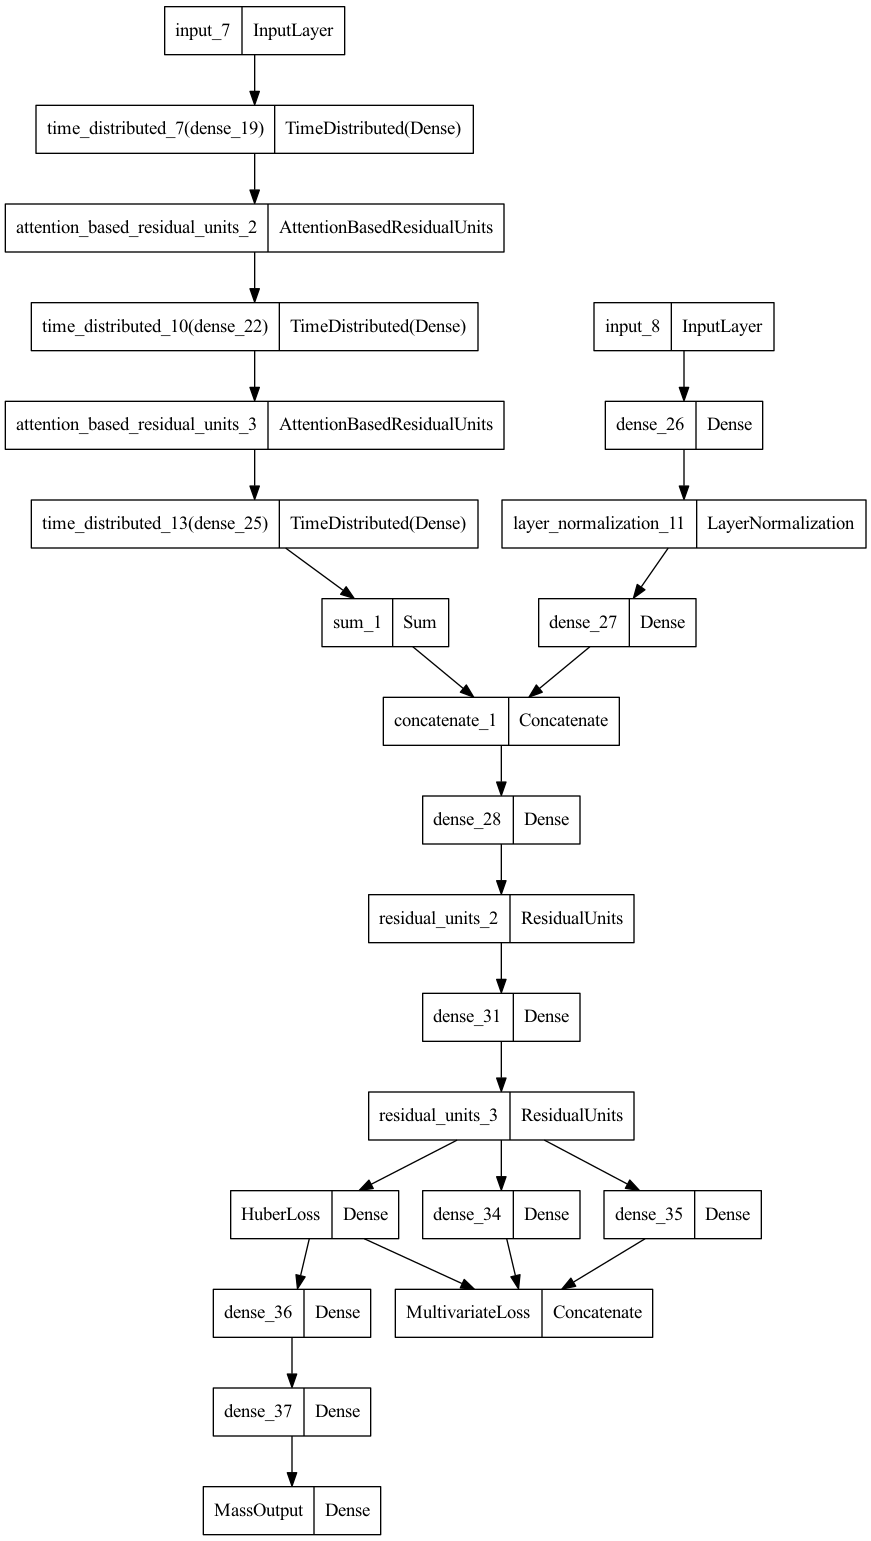

In [ ]:
tf.keras.utils.plot_model(DeepSetProjector)

In [ ]:
# Introduce early_stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    min_delta=0.00001,  # The minimum amount of change to count as an improvement
    patience=50,  # The number of epochs to wait before stopping
    restore_best_weights=True,  # Keep the best weights
)
# Prevent spikes in the validation and training loss due to the gradient descent kicking the network out of a local minima
reduce_learn_on_plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.80, patience=15, min_lr=1e-9)

# Save the weights of the model to allow reuse in future.
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPointsDeepNet/ResidualAttentionDeepSetsWeights&BiasesTrial4.ckpt"
checkpoint_dir = os.path.dirname(path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                                 save_weights_only=True, verbose=0, save_freq = 100*BATCHSIZE)
#Timer
#cb = TimingCallback()

#Weight&Biases Callback:
#Wanda = WandbCallback(save_graph = True,save_weights_only = True, log_weights = True, log_gradients = True, log_evaluation = True, training_data = (X_train,y_train), validation_data = (X_valid,y_valid), log_batch_frequency = 5)

# Learning Scheduler:
exponential_decay_fn = DSNNA.expontial_decay(lr0 = LR,s = 100)
learning_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
history  = DeepSetProjector.fit(
    (particles_input_scaled,b_jets_input_scaled), y = {"MultivariateLoss":bhads_targets_clean, "MassOutput":onehot},
    validation_split = 0.3,
    epochs = EPOCHS,
    batch_size = BATCHSIZE,
    callbacks = [early_stopping, cp_callback, reduce_learn_on_plateau],
    )

Epoch 1/1000
1043/1058 [============================>.] - ETA: 0s - loss: 21.0363 - MultivariateLoss_loss: 9.2446 - MassOutput_loss: 1.1375 - MultivariateLoss_Mean_Squared_Error: 0.8393 - MassOutput_Mean_Squared_Error: 0.1598

KeyboardInterrupt: 

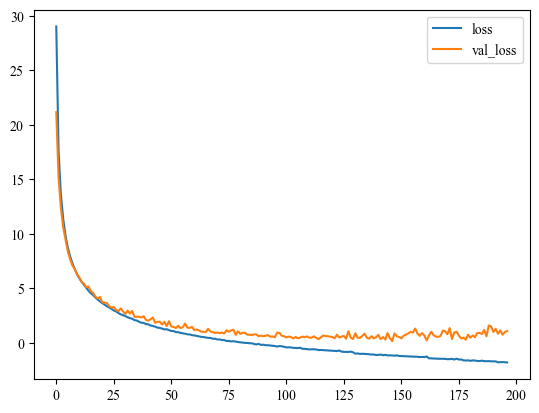

In [ ]:
# Plot the loss and validation curves vs epoch
history_df = pd.DataFrame(history.history)
(history_df.loc[:, ["loss","val_loss"]]).plot()
history_df.to_csv('/home/physics/phujdj/DeepLearningParticlePhysics/history.csv')

In [58]:
#Evaluate the entire performance of the model
loss = DeepSetProjector.evaluate((particles_input_scaled,b_jets_input_scaled),(bhads_targets_clean, onehot),verbose = 2)
print("The Loaded DeepNet has loss: ", loss)

In [83]:
predictions = DeepSetProjector.predict((Tracks_input_scaled, b_jets_input_scaled))

3021/3021 [==============================] - 17s 6ms/step


In [84]:
Predictions = np.stack([DeepSetProjector((Tracks_input_scaled, b_jets_input_scaled))[0] for sample in range(100)])
Predictions = Predictions.mean(axis = 0)

In [85]:
Predictions = predictions[0]
Predictions_Mass = predictions[1]

In [ ]:
Predictions.shape

In [86]:
lister = []
index = 0
predictions_x = Predictions[:,:np.shape(Standardized_Bhads_targets)[1]]
for bhads_features in range(np.shape(predictions_x)[1]):
    Predictions_temp = predictions_x[:, bhads_features]
    Predictions_temp = (Predictions_temp*stds_original[index]) + means_original[index]
    Predictions_temp = Predictions_temp.reshape(-1,1)
    lister.append(Predictions_temp)
    index+=1
Predictions_X = np.concatenate(lister, axis = 1)
print(Predictions_X)

[[ 3.7444727e+04  4.0507020e+04 -1.6586173e+05 ...  5.9741469e+04
   3.2177464e+01  7.1952677e-01]
 [ 1.8678537e+04  6.4115383e+04 -1.8032409e+05 ...  6.8647695e+04
   3.6770416e+01  9.5654893e-01]
 [ 4.2356805e+04  2.2125798e+03  2.2012346e+04 ...  4.0458742e+04
   8.3190041e+00  4.2511228e-01]
 ...
 [ 6.4085160e+04  8.1546070e+04  5.9153363e+04 ...  1.0167139e+05
   2.3198683e+01  9.7740483e-01]
 [ 3.6863668e+04 -2.7001070e+04 -2.8981247e+05 ...  4.8641582e+04
   5.5435448e+01  5.3084320e-01]
 [-4.8666387e+04 -3.9650447e+03 -7.6378391e+04 ...  5.2138176e+04
   1.7356716e+01  7.2886384e-01]]


In [87]:
lister = []
index = 0
predictions_x_uncertainty = Predictions[:,np.shape(Standardized_Bhads_targets)[1]:2*np.shape(Standardized_Bhads_targets)[1]]
print(predictions_x_uncertainty)
for bhads_features in range(np.shape(predictions_x_uncertainty)[1]):
    Predictions_temp = predictions_x_uncertainty[:, bhads_features]
    Predictions_temp = (Predictions_temp*stds_original[index]) + means_original[index]
    Predictions_temp = Predictions_temp.reshape(-1,1)
    lister.append(Predictions_temp)
    index+=1
Predictions_Uncertainty = np.concatenate(lister, axis = 1)
print(Predictions_Uncertainty)

[[0.17166488 0.19540425 0.23656517 ... 0.38541225 0.30469507 0.80344516]
 [0.06317557 0.21199211 0.16284166 ... 0.30540162 0.24347275 0.7173884 ]
 [0.21832886 0.04422156 0.04275565 ... 0.27271524 0.10300691 0.6037994 ]
 ...
 [0.15670207 0.18306974 0.0402297  ... 0.35774624 0.11454876 0.5566509 ]
 [0.17679617 0.1631108  0.41134366 ... 0.4093788  0.6651318  0.79381937]
 [0.24112293 0.05869751 0.12109608 ... 0.40572104 0.19909719 0.9181281 ]]
[[1.1168683e+04 1.2738397e+04 4.7277086e+04 ... 9.8765461e+04
  3.9209877e+01 9.7924936e-01]
 [4.0633142e+03 1.3822217e+04 3.2517750e+04 ... 9.5391305e+04
  3.7490852e+01 9.5811939e-01]
 [1.4224881e+04 2.8604060e+03 8.4767100e+03 ... 9.4012875e+04
  3.3546787e+01 9.3022931e-01]
 ...
 [1.0188713e+04 1.1932483e+04 7.9710190e+03 ... 9.7598750e+04
  3.3870865e+01 9.1865271e-01]
 [1.1504750e+04 1.0628404e+04 8.2267477e+04 ... 9.9776164e+04
  4.9330379e+01 9.7688586e-01]
 [1.5717749e+04 3.8062375e+03 2.4160348e+04 ... 9.9621914e+04
  3.6244854e+01 1.007408

In [88]:
Error_px_unscaled = bhads_targets_clean[:,0] - Predictions_X[:,0]
Pull_bhads_px_unscaled = Error_px_unscaled/np.std(bhads_targets_clean[:,0])
Pull_px = Error_px_unscaled/Predictions_Uncertainty[:,0]

In [89]:
Error_py_unscaled = bhads_targets_clean[:,1] - Predictions_X[:,1]
Pull_bhads_py_unscaled = Error_py_unscaled/np.std(bhads_targets_clean[:,1])
Pull_py = Error_py_unscaled/Predictions_Uncertainty[:,1]

In [90]:
Error_pz_unscaled = bhads_targets_clean[:,2] - Predictions_X[:,2]
Pull_bhads_pz_unscaled = Error_pz_unscaled/np.std(bhads_targets_clean[:,2])
Pull_pz = Error_pz_unscaled/Predictions_Uncertainty[:,2]

In [91]:
Error_pt_unscaled = bhads_targets_clean[:,3] - Predictions_X[:,3]
Pull_bhads_pt_unscaled = Error_pt_unscaled/np.std(bhads_targets_clean[:,3])
Pull_pt = Error_pt_unscaled/Predictions_Uncertainty[:,3]

In [92]:
Error_eta_unscaled = bhads_targets_clean[:,4] - Predictions_X[:,4]
Pull_bhads_eta_unscaled = Error_eta_unscaled/np.std(bhads_targets_clean[:,4])
Pull_eta = Error_eta_unscaled/Predictions_Uncertainty[:,4]

In [93]:
Error_phi_unscaled = bhads_targets_clean[:,5] - Predictions_X[:,5]
Pull_bhads_pt_unscaled = Error_pt_unscaled/np.std(bhads_targets_clean[:,5])
Pull_phi = Error_phi_unscaled/Predictions_Uncertainty[:,5]

In [94]:
Error_pxfraction_unscaled = bhads_targets_clean[:,6] - Predictions_X[:,6]
Pull_pxfraction_unscaled = Error_pxfraction_unscaled/np.std(bhads_targets_clean[:,6])
Pull_pxfraction = Error_pxfraction_unscaled/Predictions_Uncertainty[:,6]

In [95]:
Error_pyfraction_unscaled = bhads_targets_clean[:,7] - Predictions_X[:,7]
Pull_pyfraction_unscaled = Error_pyfraction_unscaled/np.std(bhads_targets_clean[:,7])
Pull_pyfraction = Error_pyfraction_unscaled/Predictions_Uncertainty[:,7]

In [96]:
Error_pzfraction_unscaled = bhads_targets_clean[:,8] - Predictions_X[:,8]
Pull_pzfraction_unscaled = Error_pzfraction_unscaled/np.std(bhads_targets_clean[:,8])
Pull_pzfraction = Error_pzfraction_unscaled/Predictions_Uncertainty[:,8]

In [97]:
Error_energy_unscaled = bhads_targets_clean[:,9] - Predictions_X[:,9]
Pull_energy_unscaled = Error_energy_unscaled/np.std(bhads_targets_clean[:,9])
Pull_energy = Error_energy_unscaled/Predictions_Uncertainty[:,8]

In [98]:
Error_projection_unscaled = bhads_targets_clean[:,12] - Predictions_X[:,12]
Pull_bhads_projection_unscaled = Error_projection_unscaled/np.std(bhads_targets_clean[:,12])
Pull_projection = Error_projection_unscaled/Predictions_Uncertainty[:,12]

In [55]:
Error_mass_unscaled = bhads_targets_clean[:,13] - Predictions_X[:, 13]
Pull_mass_unscaled = Error_energy_unscaled/np.std(bhads_targets_clean[:,13])
Pull_mass = Error_energy_unscaled/Predictions_Uncertainty[:,13]

IndexError: index 13 is out of bounds for axis 1 with size 13

In [ ]:
Error_Secondary_Displacement_unscaled = bhads_targets_clean[:,14] - Predictions_X[:, 14]
Pull_Secondary_Displacement_unscaled = Error_Secondary_Displacement_unscaled/np.std(bhads_targets_clean[:,14])
Pull_Secondary_Displacement = Error_Secondary_Displacement_unscaled/Predictions_Uncertainty[:,14]

In [99]:
Predictions_X.shape

(96657, 13)

In [100]:
len(means), len(stds)

(13, 13)

In [58]:
means_original, stds_original = means, stds

114.54685639642639
16210.988759369213


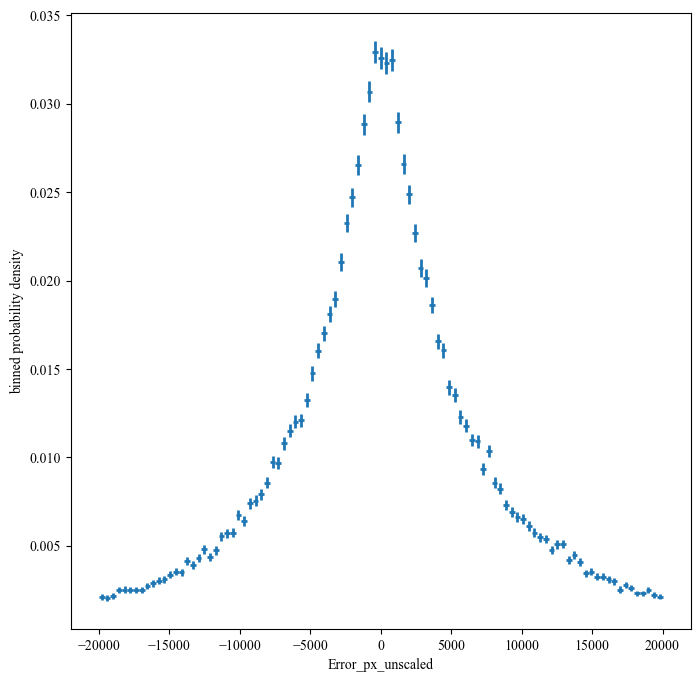

In [101]:
print(np.mean(Error_px_unscaled))
print(np.std(Error_px_unscaled))
binneddensity(Error_px_unscaled, fixedbinning(-20000,20000,100),xlabel = "Error_px_unscaled")

0.008109493008466584
0.8982539280869529


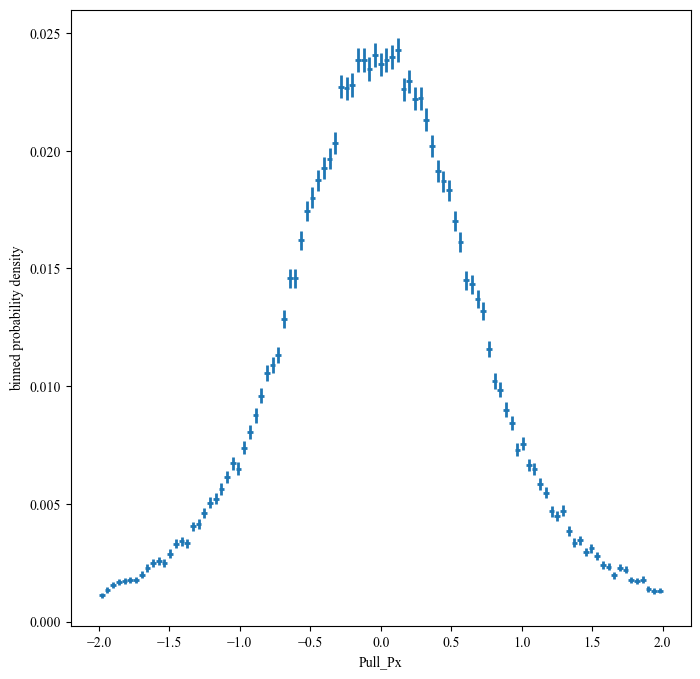

In [102]:
print(np.mean(Pull_px))
print(np.std(Pull_px))
binneddensity(Pull_px, fixedbinning(-2,2,100),xlabel = "Pull_Px")

623.1496409937243
15948.003754157004


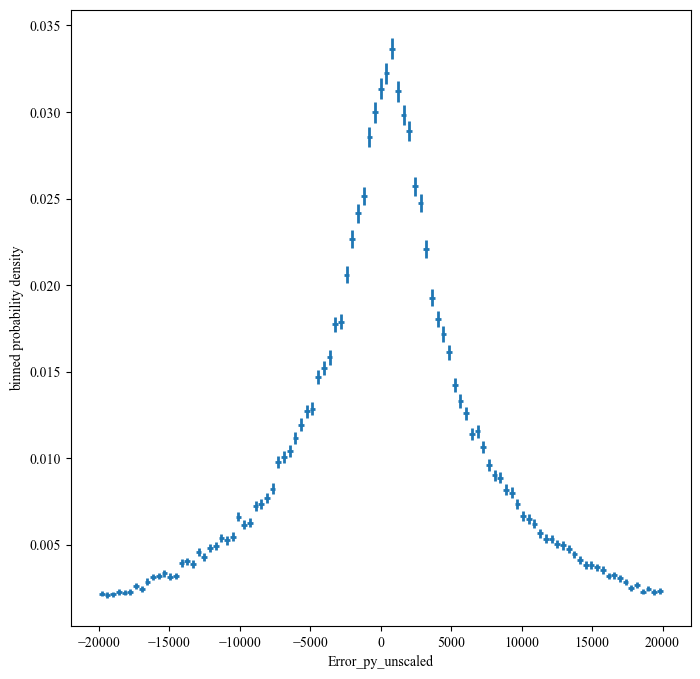

In [103]:
print(np.mean(Error_py_unscaled))
print(np.std(Error_py_unscaled))
binneddensity(Error_py_unscaled, fixedbinning(-20000,20000,100),xlabel = "Error_py_unscaled")

0.06725192073272411
0.9229579446106472


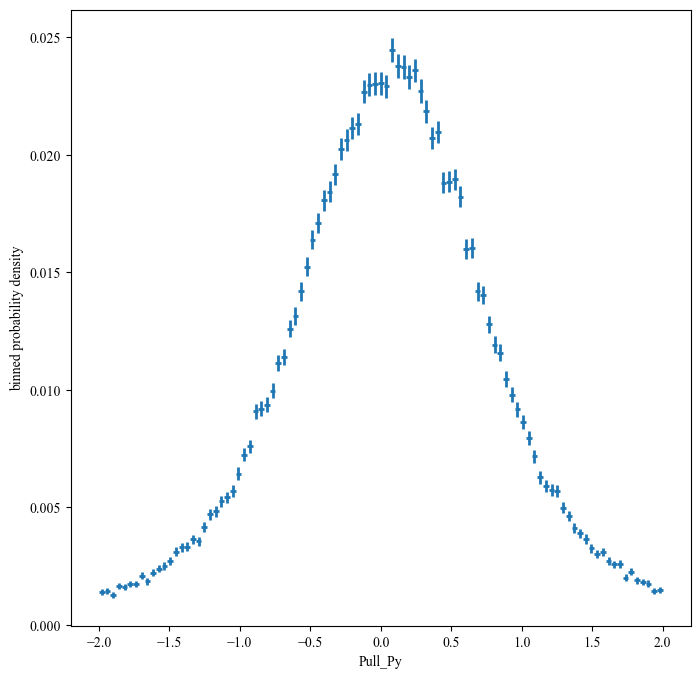

In [104]:
print(np.mean(Pull_py))
print(np.std(Pull_py))
binneddensity(Pull_py, fixedbinning(-2,2,100),xlabel = "Pull_Py")

-1072.6788856927897
51058.29353454977


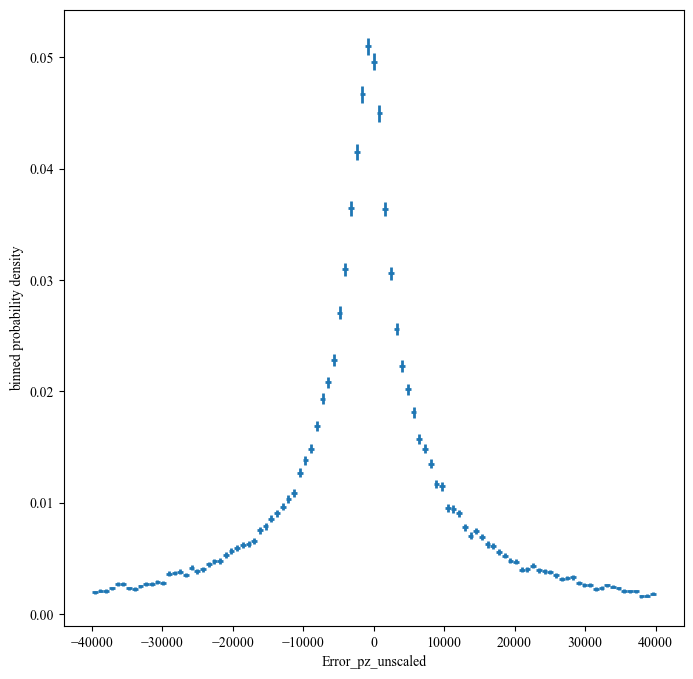

In [105]:
print(np.mean(Error_pz_unscaled))
print(np.std(Error_pz_unscaled))
binneddensity(Error_pz_unscaled, fixedbinning(-40000,40000,100),xlabel = "Error_pz_unscaled")

-0.09261812607186756
0.9211557182397959


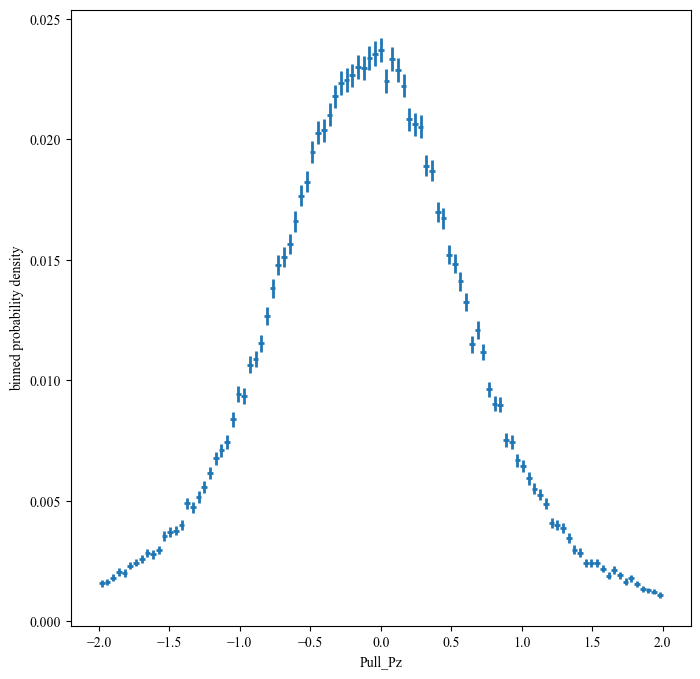

In [106]:
print(np.mean(Pull_pz))
print(np.std(Pull_pz))
binneddensity(Pull_pz, fixedbinning(-2,2,100),xlabel = "Pull_Pz")

0.0017797664944246925
0.18158183853689638


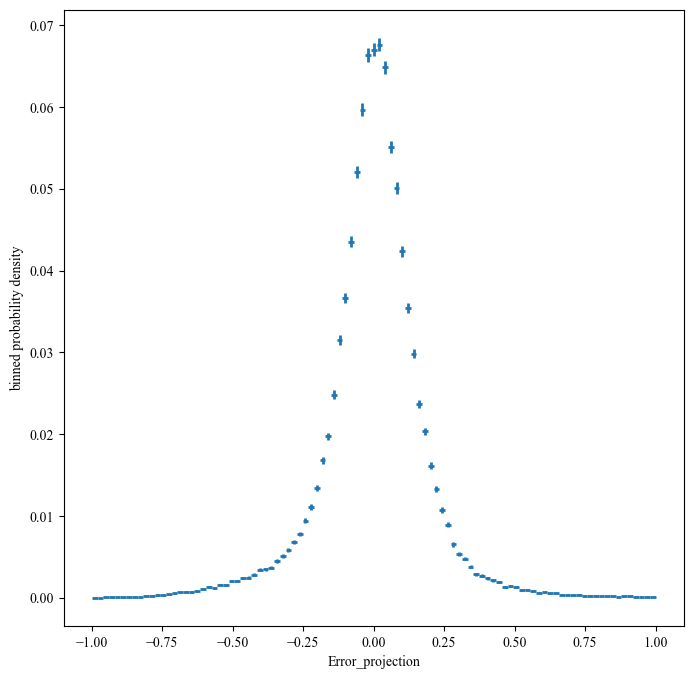

In [107]:
print(np.mean(Error_projection_unscaled))
print(np.std(Error_projection_unscaled))
binneddensity(Error_projection_unscaled, fixedbinning(-1,1,100),xlabel = "Error_projection")

0.0013342010470901782
0.1805118193135011


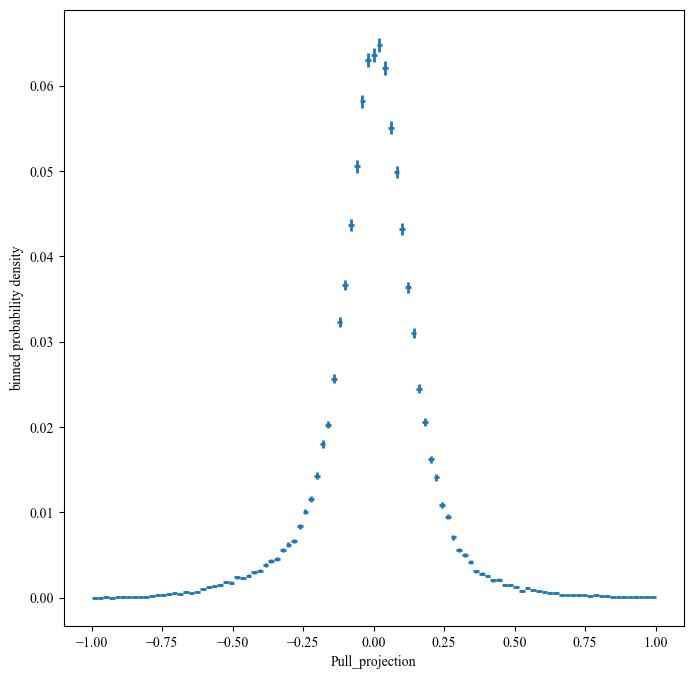

In [108]:
print(np.mean(Pull_projection))
print(np.std(Pull_projection))
binneddensity(Pull_projection, fixedbinning(-1,1,100),xlabel = "Pull_projection")

-0.05660919625558818
14.830863280967073


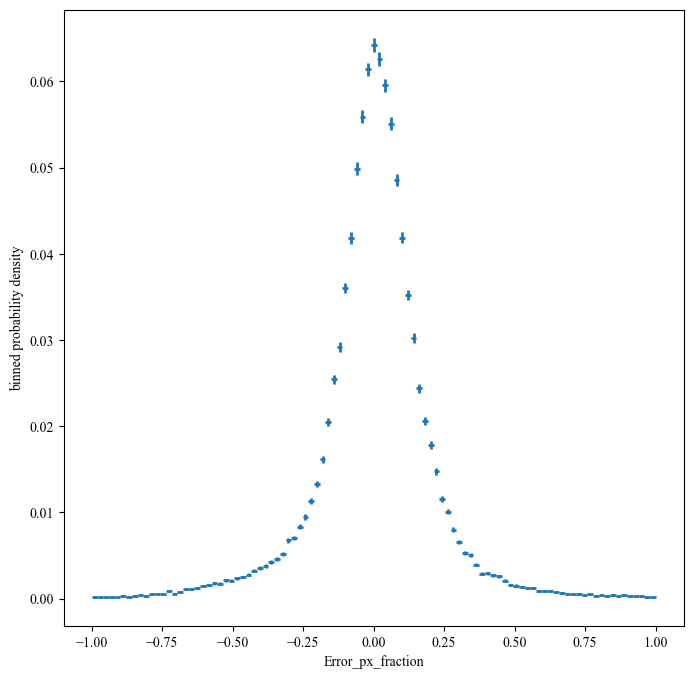

In [109]:
print(np.mean(Error_pxfraction_unscaled))
print(np.std(Error_pxfraction_unscaled))
binneddensity(Error_pxfraction_unscaled, fixedbinning(-1,1,100),xlabel = "Error_px_fraction")

-0.003816873770287589
0.999970619477865


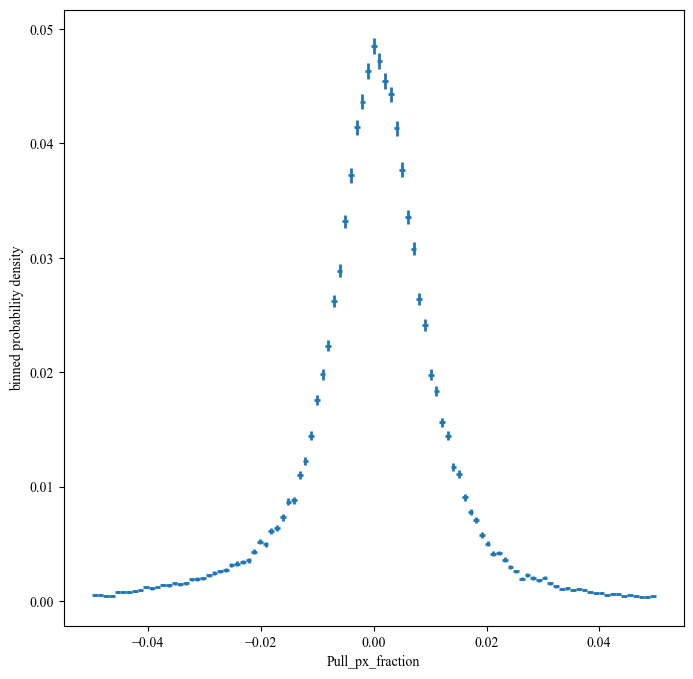

In [110]:
print(np.mean(Pull_pxfraction_unscaled))
print(np.std(Pull_pxfraction_unscaled))
binneddensity(Pull_pxfraction_unscaled, fixedbinning(-0.05,0.05,100),xlabel = "Pull_px_fraction")

-0.3500970174703216
110.86716611441628


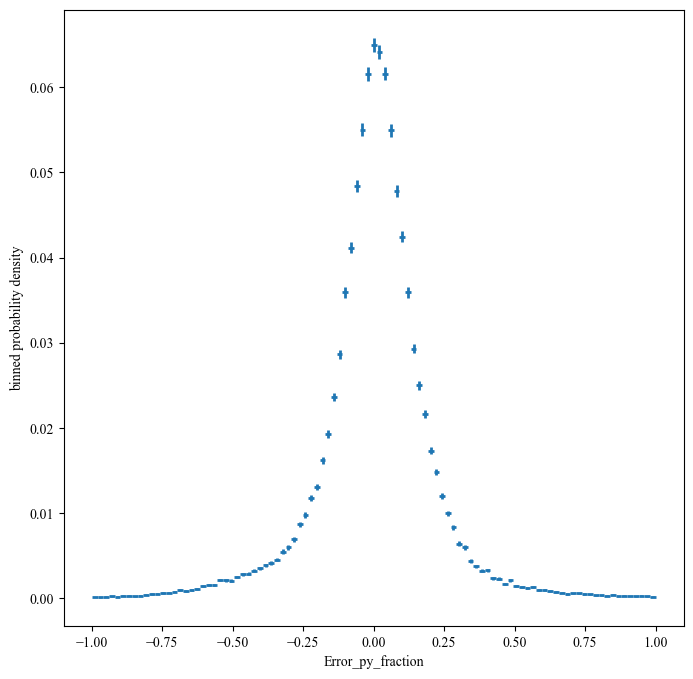

In [111]:
print(np.mean(Error_pyfraction_unscaled))
print(np.std(Error_pyfraction_unscaled))
binneddensity(Error_pyfraction_unscaled, fixedbinning(-1,1,100),xlabel = "Error_py_fraction")

-0.003157787168919376
0.9999939934942039


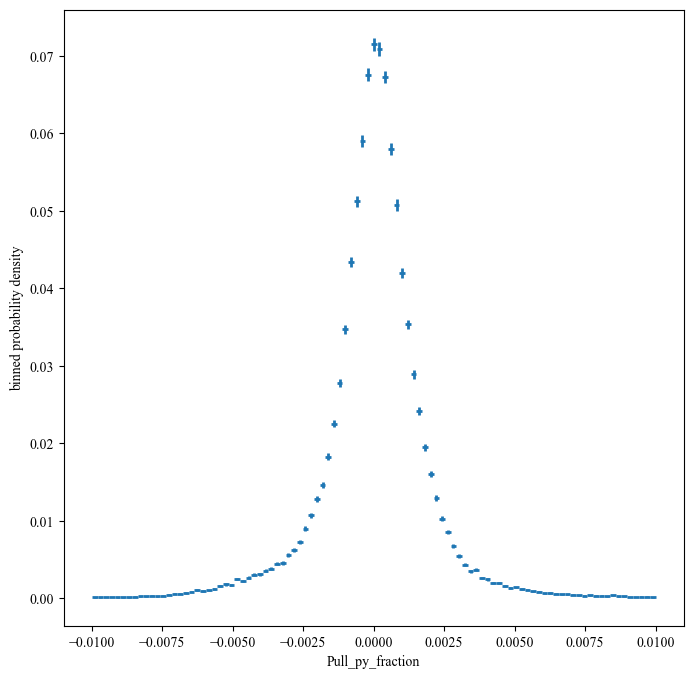

In [126]:
print(np.mean(Pull_pyfraction_unscaled))
print(np.std(Pull_pyfraction_unscaled))
binneddensity(Pull_pyfraction_unscaled, fixedbinning(-0.01,0.01,100),xlabel = "Pull_py_fraction")

0.0015052802032405092
3.034936944464101


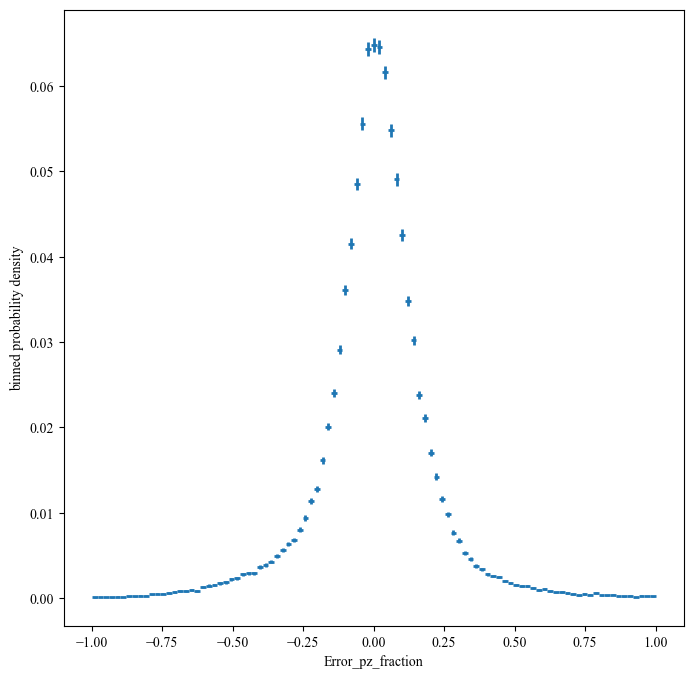

In [113]:
print(np.mean(Error_pzfraction_unscaled))
print(np.std(Error_pzfraction_unscaled))
binneddensity(Error_pzfraction_unscaled, fixedbinning(-1,1,100),xlabel = "Error_pz_fraction")

0.0004952350846939251
0.9984900163416655


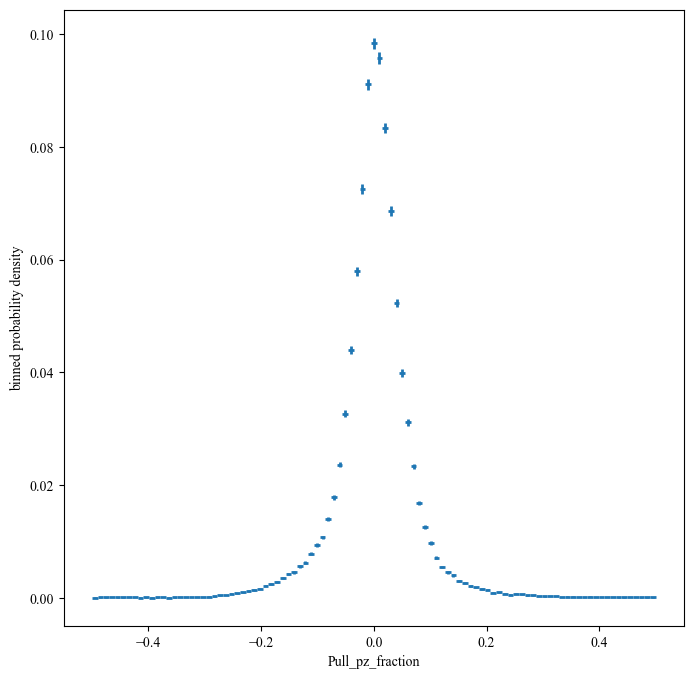

In [114]:
print(np.mean(Pull_pzfraction_unscaled))
print(np.std(Pull_pzfraction_unscaled))
binneddensity(Pull_pzfraction_unscaled, fixedbinning(-0.5,0.5,100),xlabel = "Pull_pz_fraction")

-329.49037753452603
52681.6045831306


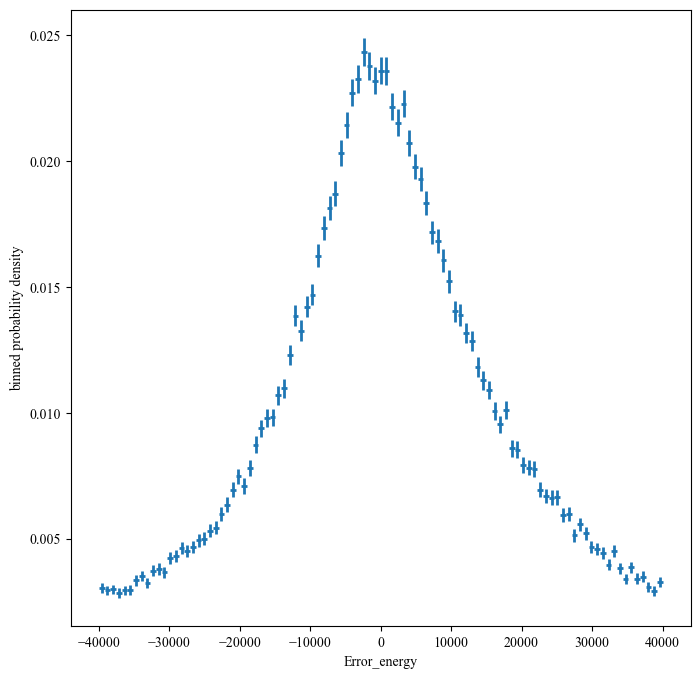

In [115]:
print(np.mean(Error_energy_unscaled))
print(np.std(Error_energy_unscaled))
binneddensity(Error_energy_unscaled, fixedbinning(-40000,40000,100),xlabel = "Error_energy")

-0.002213657539425988
0.3539375931009873


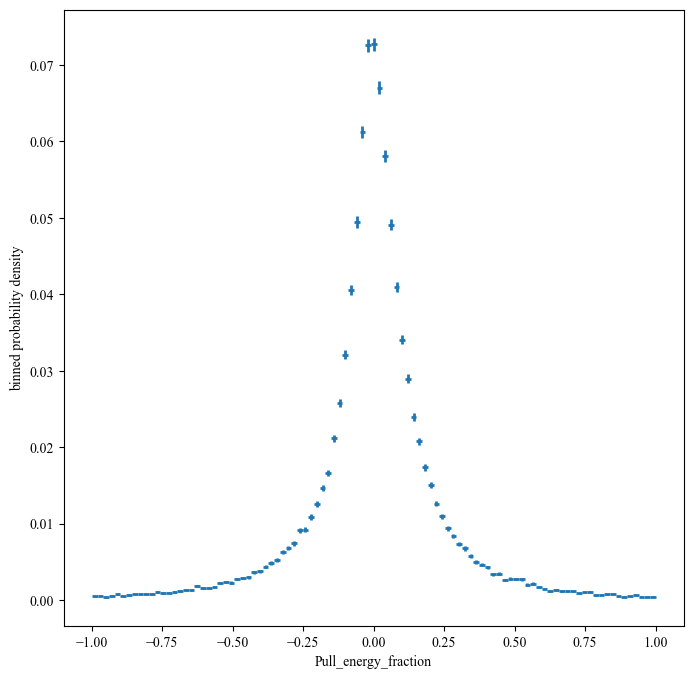

In [116]:
print(np.mean(Pull_energy_unscaled))
print(np.std(Pull_energy_unscaled))
binneddensity(Pull_energy_unscaled, fixedbinning(-1,1,100),xlabel = "Pull_energy_fraction")

1.2034048610355623
88.82954199477032


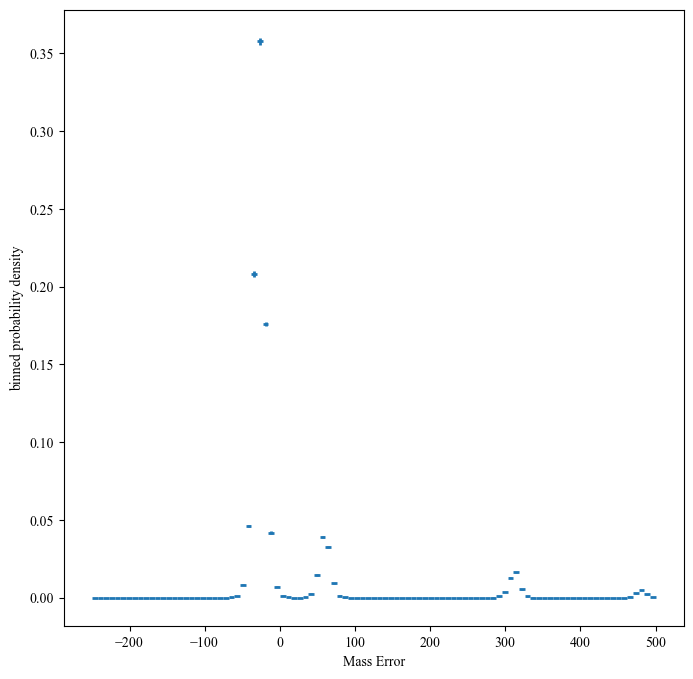

In [278]:
print(np.mean(Error_mass_unscaled))
print(np.std(Error_mass_unscaled))
binneddensity(Error_mass_unscaled, fixedbinning(-250,500,100),xlabel = "Mass Error")

-252.58499606190415
22031.110523051342


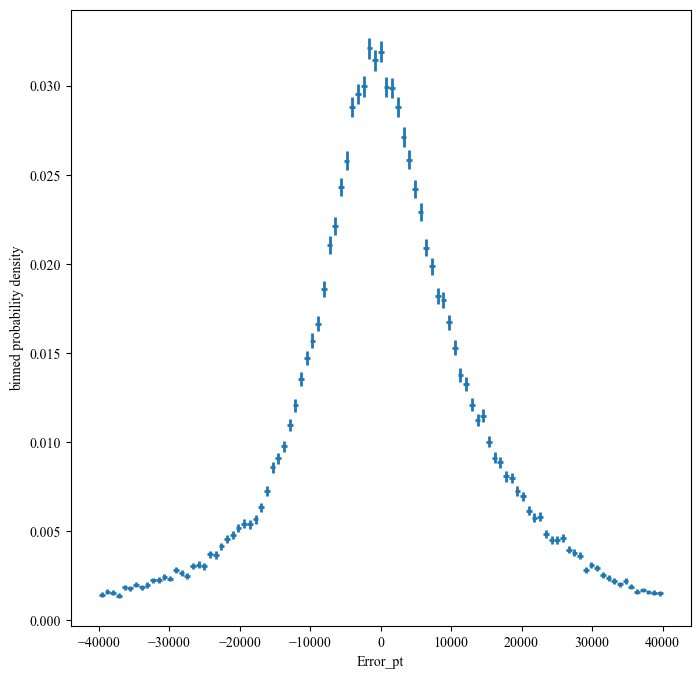

In [117]:
print(np.mean(Error_pt_unscaled))
print(np.std(Error_pt_unscaled))
binneddensity(Error_pt_unscaled, fixedbinning(-40000,40000,100),xlabel = "Error_pt")

-0.002689869649959834
0.1877718661663591


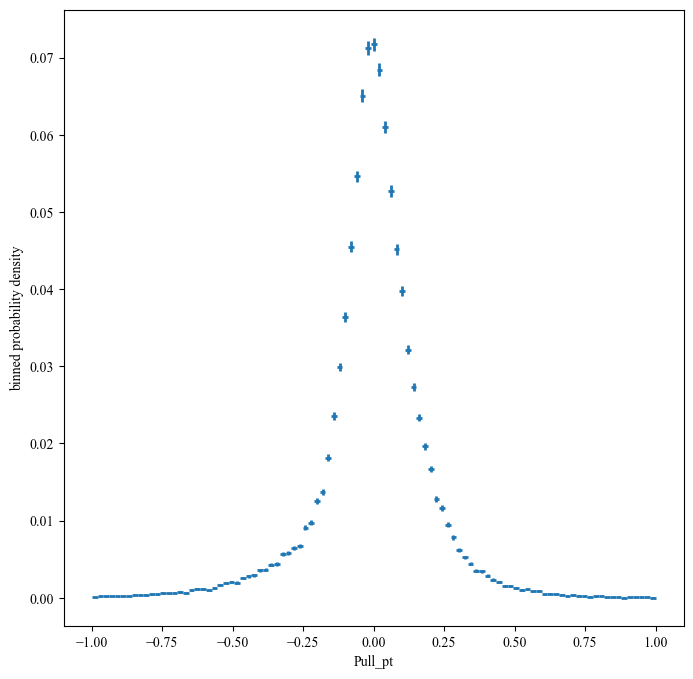

In [118]:
print(np.mean(Pull_pt))
print(np.std(Pull_pt))
binneddensity(Pull_pt, fixedbinning(-1,1,100),xlabel = "Pull_pt")

-0.0025516545908837686
0.06167620448379536


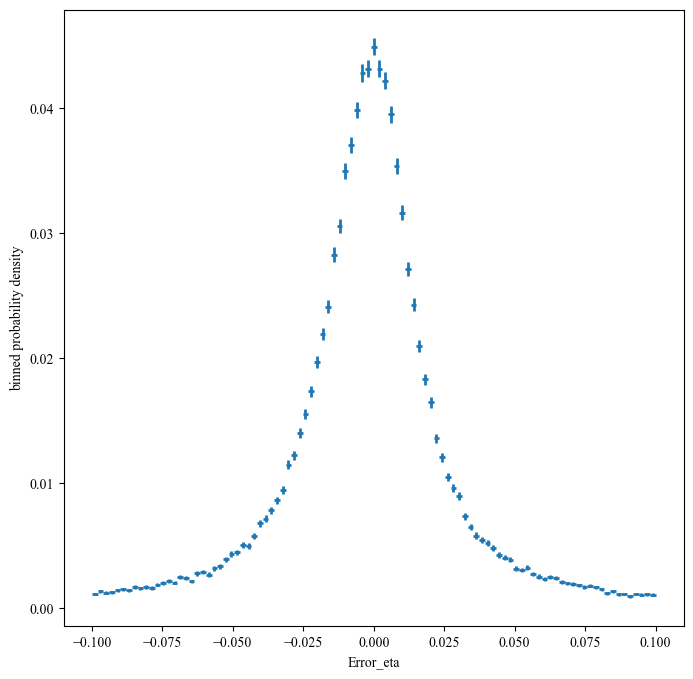

In [119]:
print(np.mean(Error_eta_unscaled))
print(np.std(Error_eta_unscaled))
binneddensity(Error_eta_unscaled, fixedbinning(-0.1,0.1,100),xlabel = "Error_eta")

-0.05122126249656387
0.9320642500461408


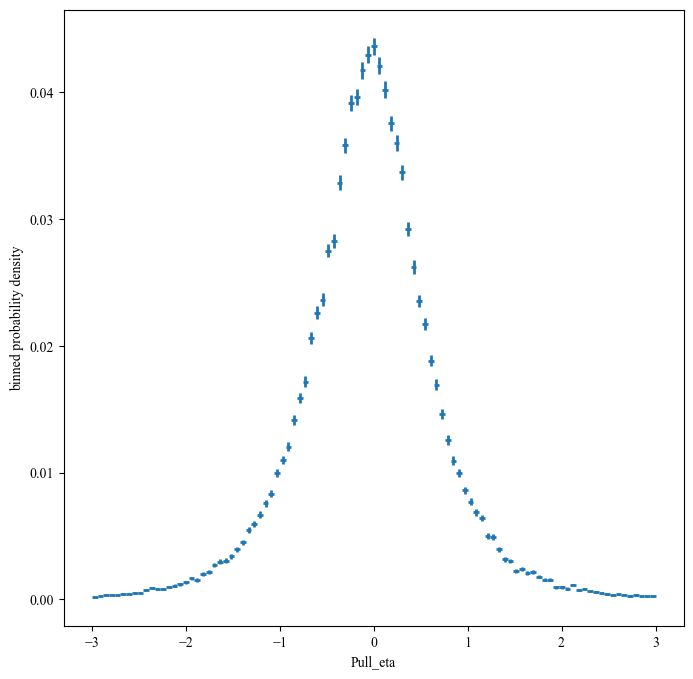

In [120]:
print(np.mean(Pull_eta))
print(np.std(Pull_eta))
binneddensity(Pull_eta, fixedbinning(-3,3,100),xlabel = "Pull_eta")

-0.0013338881433987487
0.3717700677407939


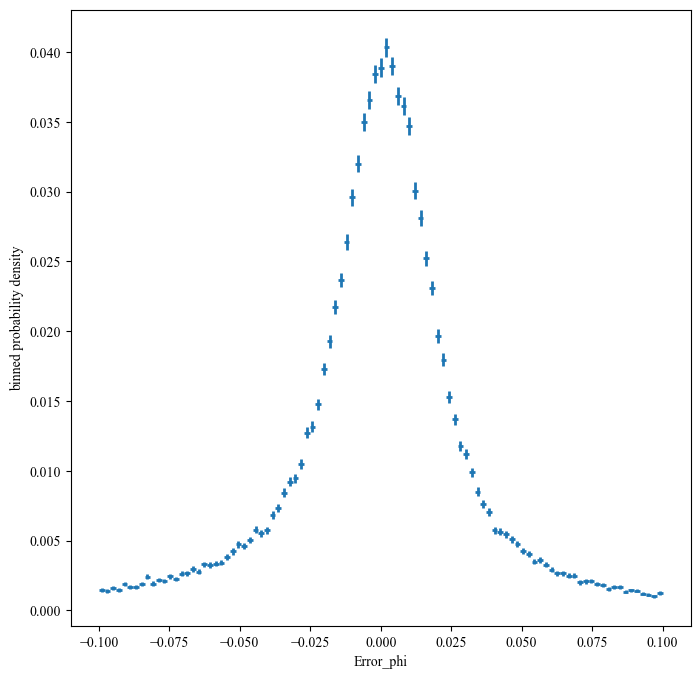

In [121]:
print(np.mean(Error_phi_unscaled))
print(np.std(Error_phi_unscaled))
binneddensity(Error_phi_unscaled, fixedbinning(-0.1,0.1,100),xlabel = "Error_phi")

0.01709149939140298
0.9281425419908942


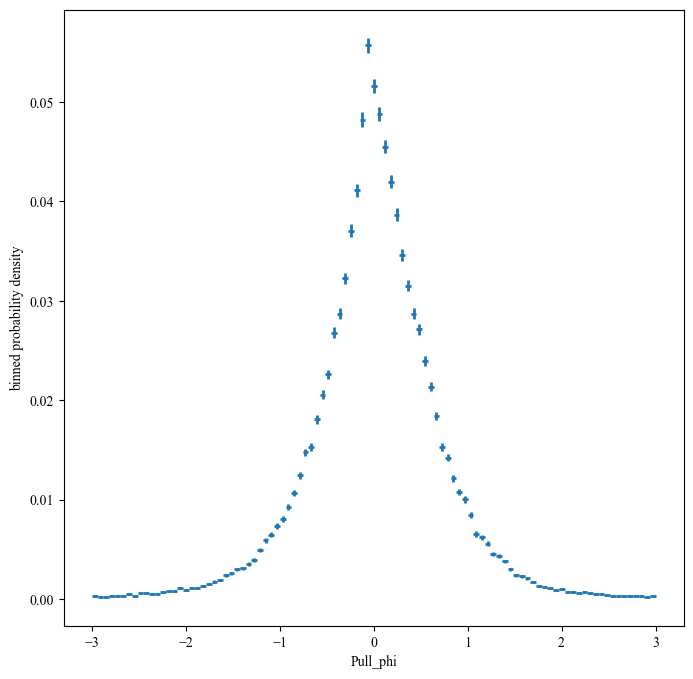

In [122]:
print(np.mean(Pull_phi))
print(np.std(Pull_phi))
binneddensity(Pull_phi, fixedbinning(-3,3,100),xlabel = "Pull_phi")

In [123]:
print(np.median(Error_Secondary_Displacement_unscaled))
print(np.std(Error_Secondary_Displacement_unscaled))
binneddensity(Error_Secondary_Displacement_unscaled, fixedbinning(-10,10,100),xlabel = "Error_SecondaryVertex")

NameError: name 'Error_Secondary_Displacement_unscaled' is not defined

-0.24390834326138106
0.5755718334727971


/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


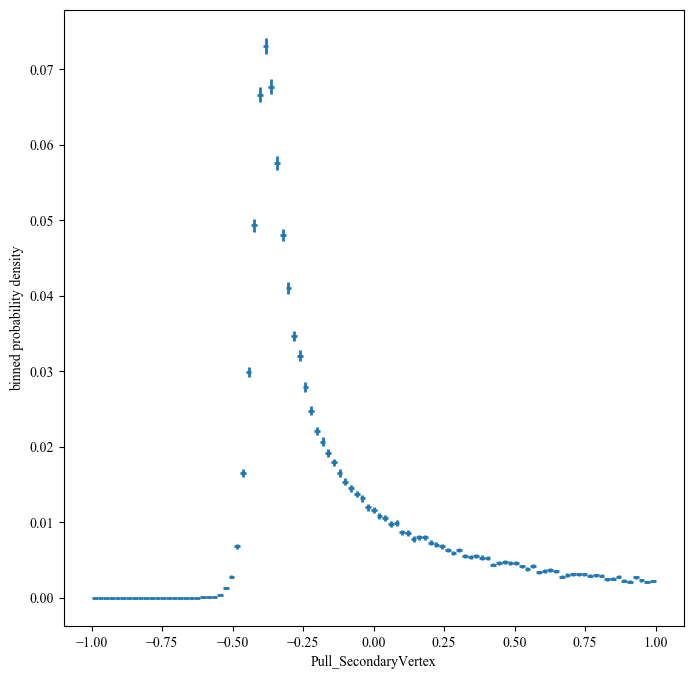

In [287]:
print(np.median(Pull_Secondary_Displacement))
print(np.std(Pull_Secondary_Displacement))
binneddensity(Pull_Secondary_Displacement, fixedbinning(-1,1,100),xlabel = "Pull_SecondaryVertex")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted X momenta of b hadron jets')

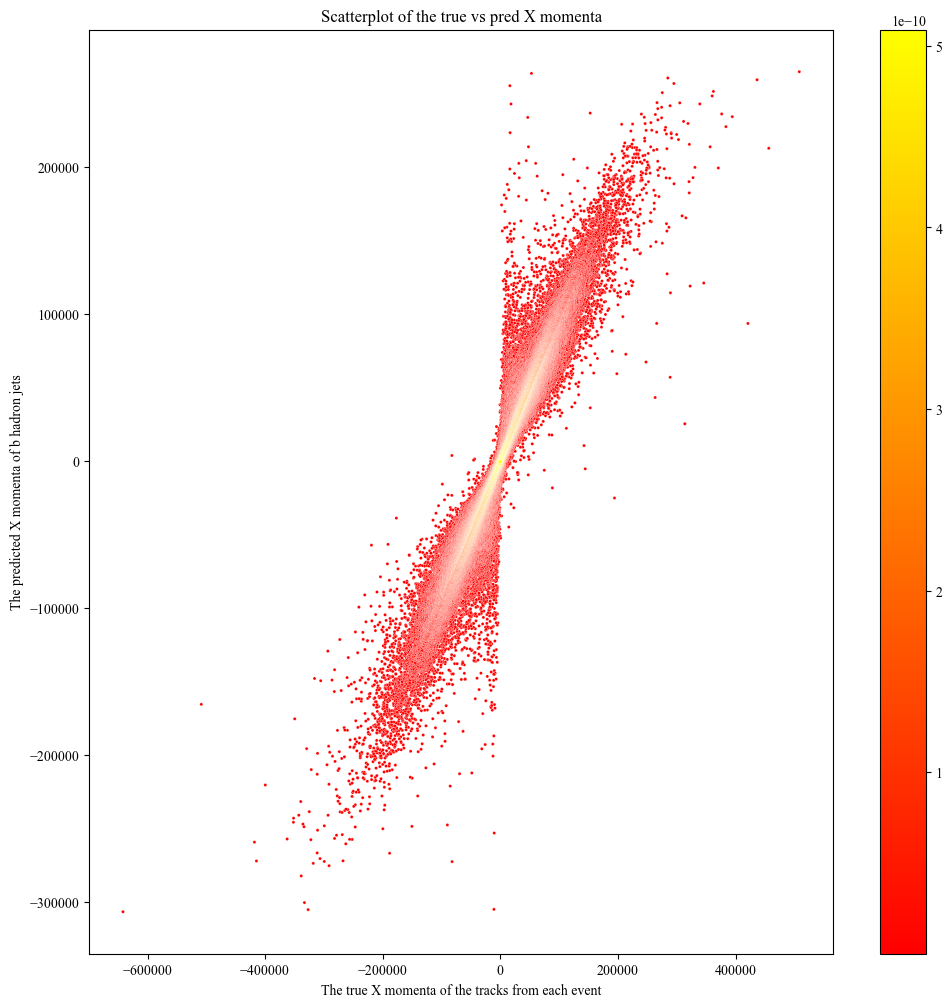

In [124]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,0]
y = Predictions_X[:,0]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "autumn",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "autumn", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")

In [ ]:
[bhads[:,0],bhads[:,1], bhads[:,2], bhads_pt, bhads_eta, bhads_phi, bhads_fractions_px, bhads_fractions_py, bhads_fractions_pz, bhads_energy, bhads_transverse_mass, bhads_energy_mass_ratio, bhads_projection, bhads_m, Secondary_Displacement]

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted Y momenta of b hadron jets')

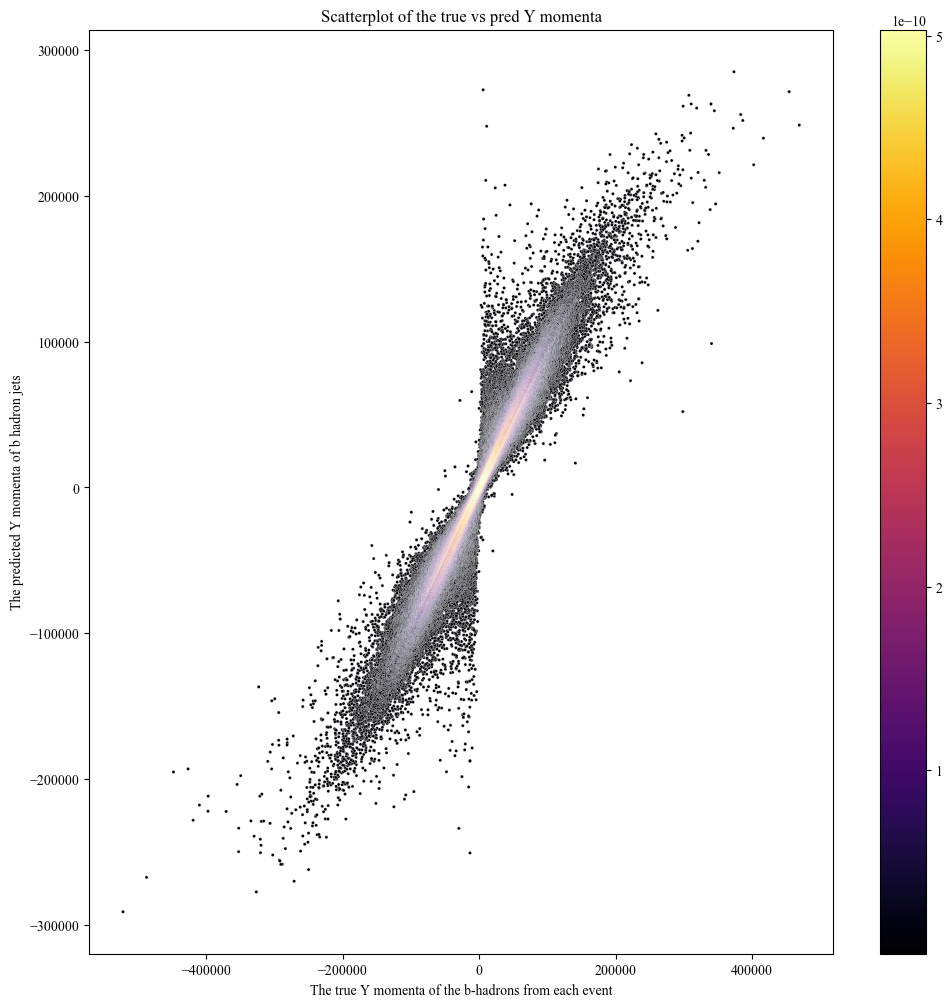

In [125]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,1]
y = Predictions_X[:,1]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "inferno",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "inferno", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Y momenta")
ax.set_xlabel("The true Y momenta of the b-hadrons from each event")
ax.set_ylabel("The predicted Y momenta of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted Z momenta of b hadron jets')

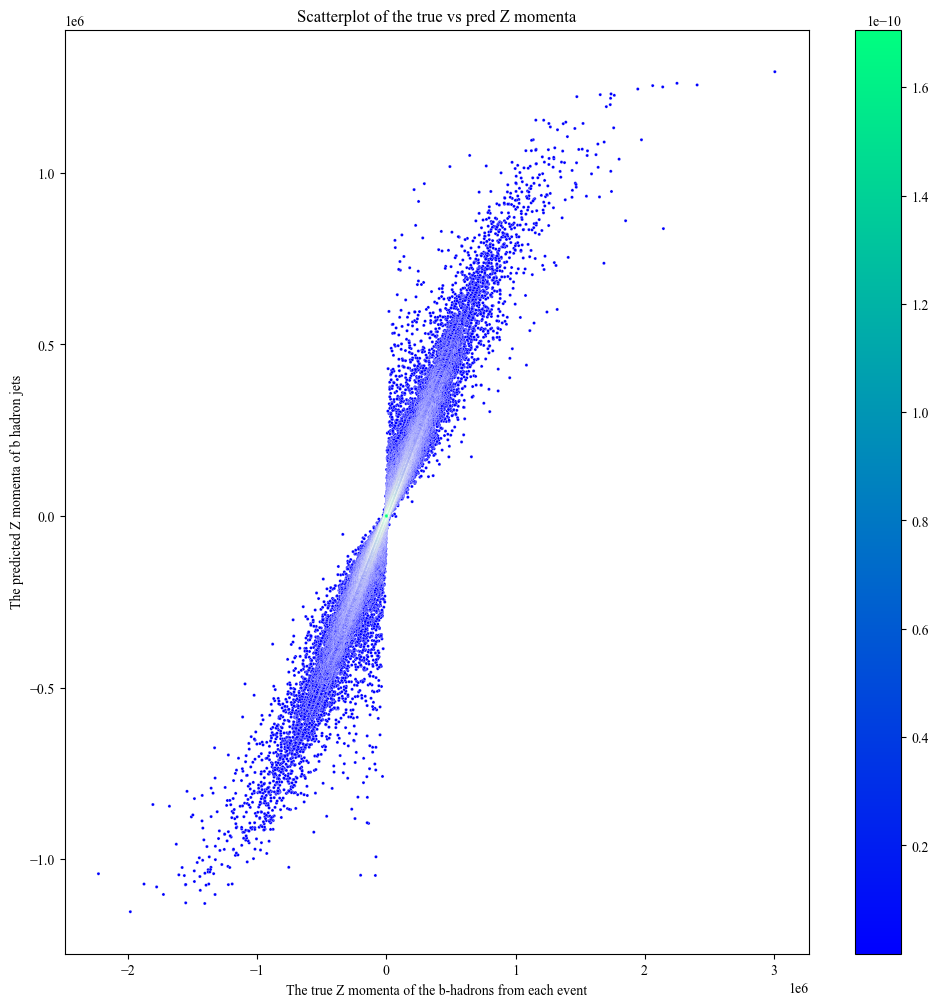

In [205]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,2]
y = Predictions_X[:,2]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "winter",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "winter", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Z momenta")
ax.set_xlabel("The true Z momenta of the b-hadrons from each event")
ax.set_ylabel("The predicted Z momenta of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted transverse momenta of b hadron jets')

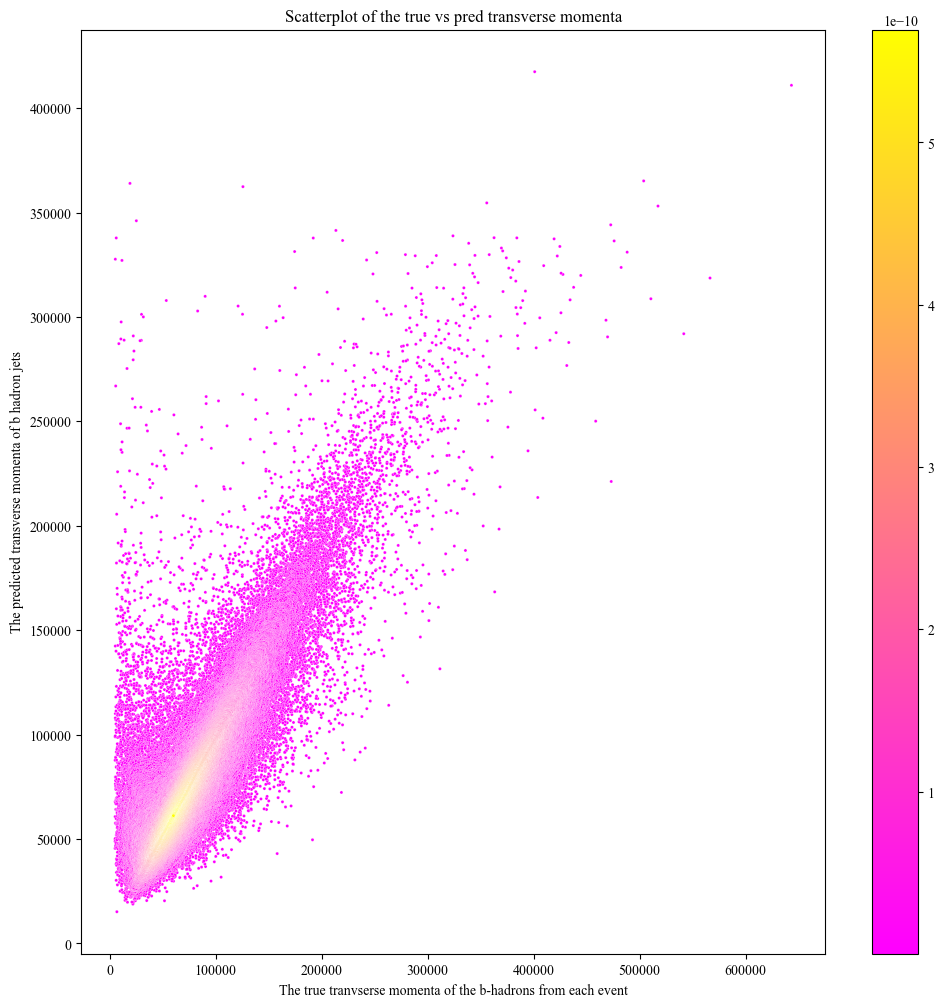

In [206]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,3]
y = Predictions_X[:,3]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "spring",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "spring", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred transverse momenta")
ax.set_xlabel("The true tranvserse momenta of the b-hadrons from each event")
ax.set_ylabel("The predicted transverse momenta of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted pseudorapidity of b hadron jets')

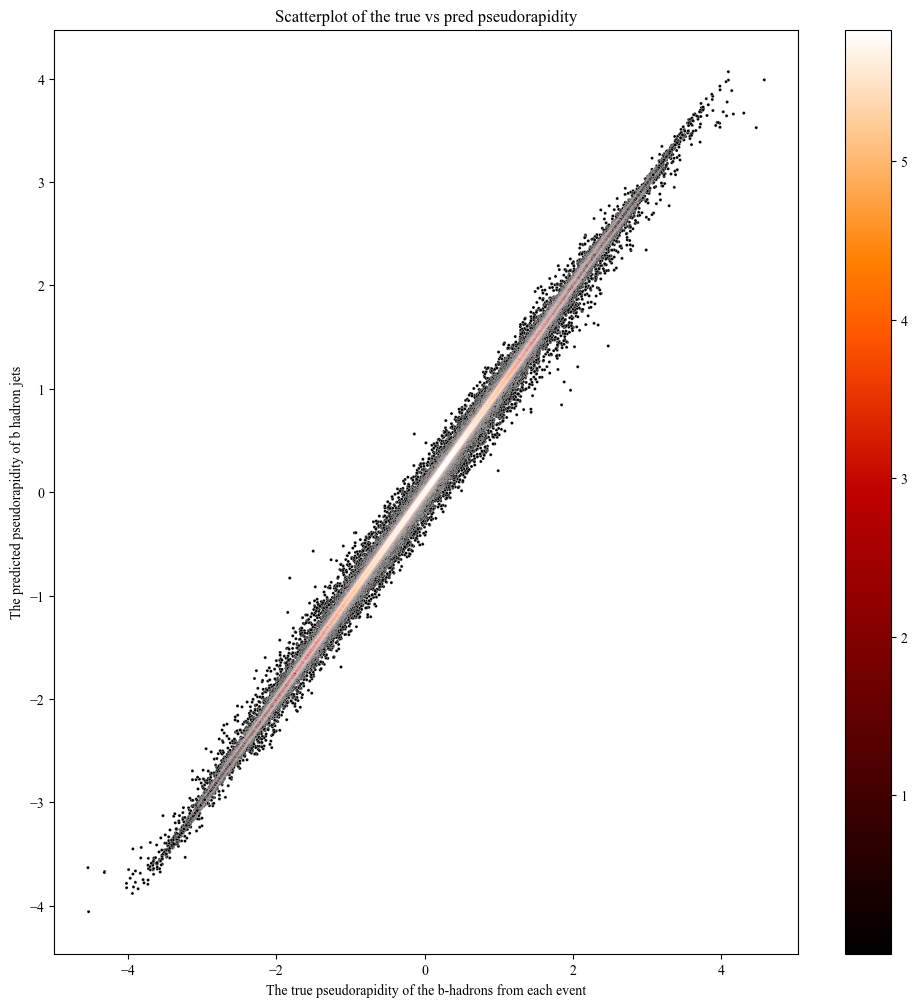

In [207]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,4]
y = Predictions_X[:,4]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "gist_heat",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "gist_heat", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred pseudorapidity")
ax.set_xlabel("The true pseudorapidity of the b-hadrons from each event")
ax.set_ylabel("The predicted pseudorapidity of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted phi of b hadron jets')

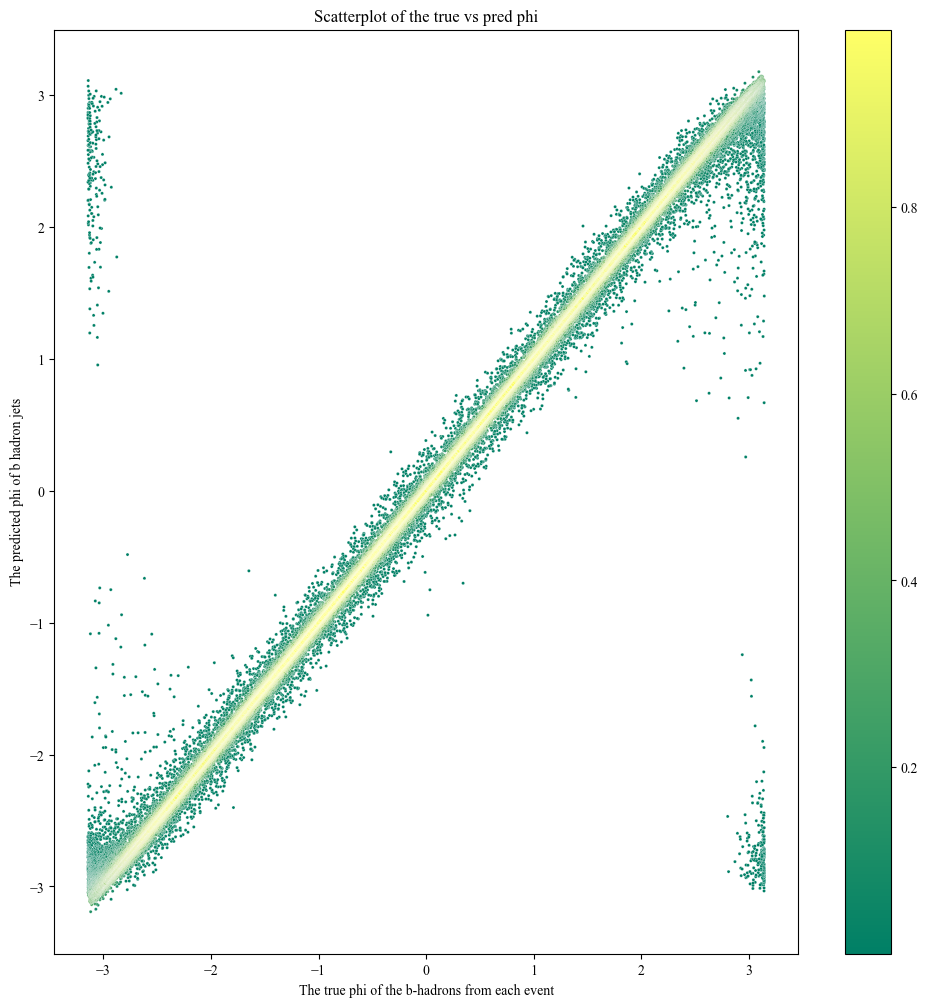

In [208]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,5]
y = Predictions_X[:,5]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "summer",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "summer", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred phi")
ax.set_xlabel("The true phi of the b-hadrons from each event")
ax.set_ylabel("The predicted phi of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted X fraction of b hadron jets')

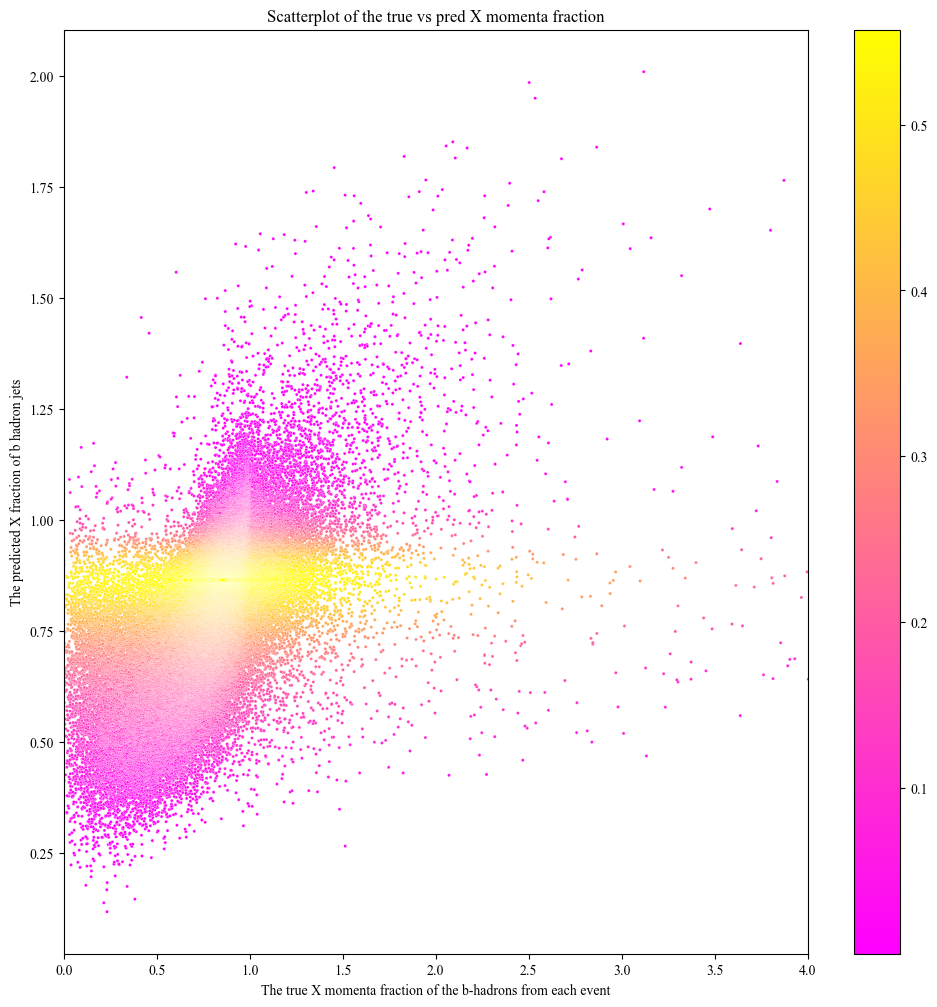

In [222]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,6]
y = Predictions_X[:,6]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "spring",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "spring", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_xlim([0,4])
ax.set_title("Scatterplot of the true vs pred X momenta fraction")
ax.set_xlabel("The true X momenta fraction of the b-hadrons from each event")
ax.set_ylabel("The predicted X fraction of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted Y fraction of b hadron jets')

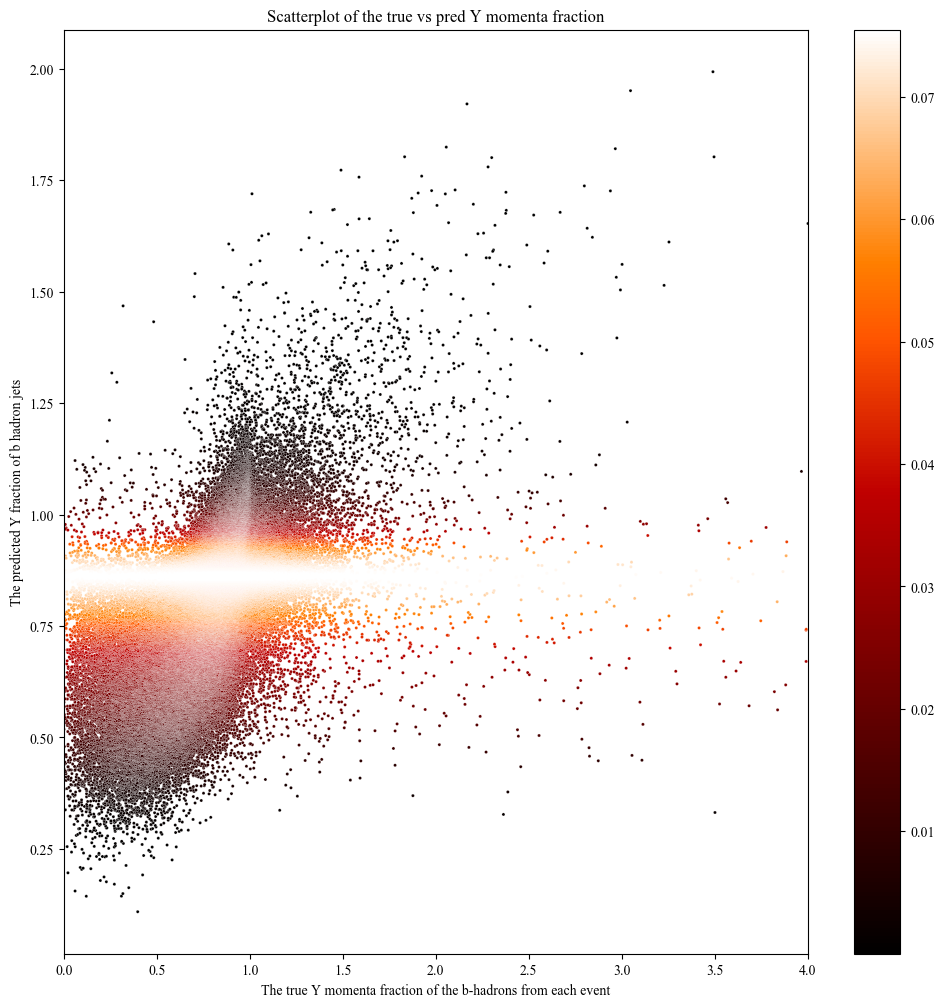

In [221]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,7]
y = Predictions_X[:,7]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "gist_heat",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "gist_heat", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_xlim([0,4])
ax.set_title("Scatterplot of the true vs pred Y momenta fraction")
ax.set_xlabel("The true Y momenta fraction of the b-hadrons from each event")
ax.set_ylabel("The predicted Y fraction of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted Z fraction of b hadron jets')

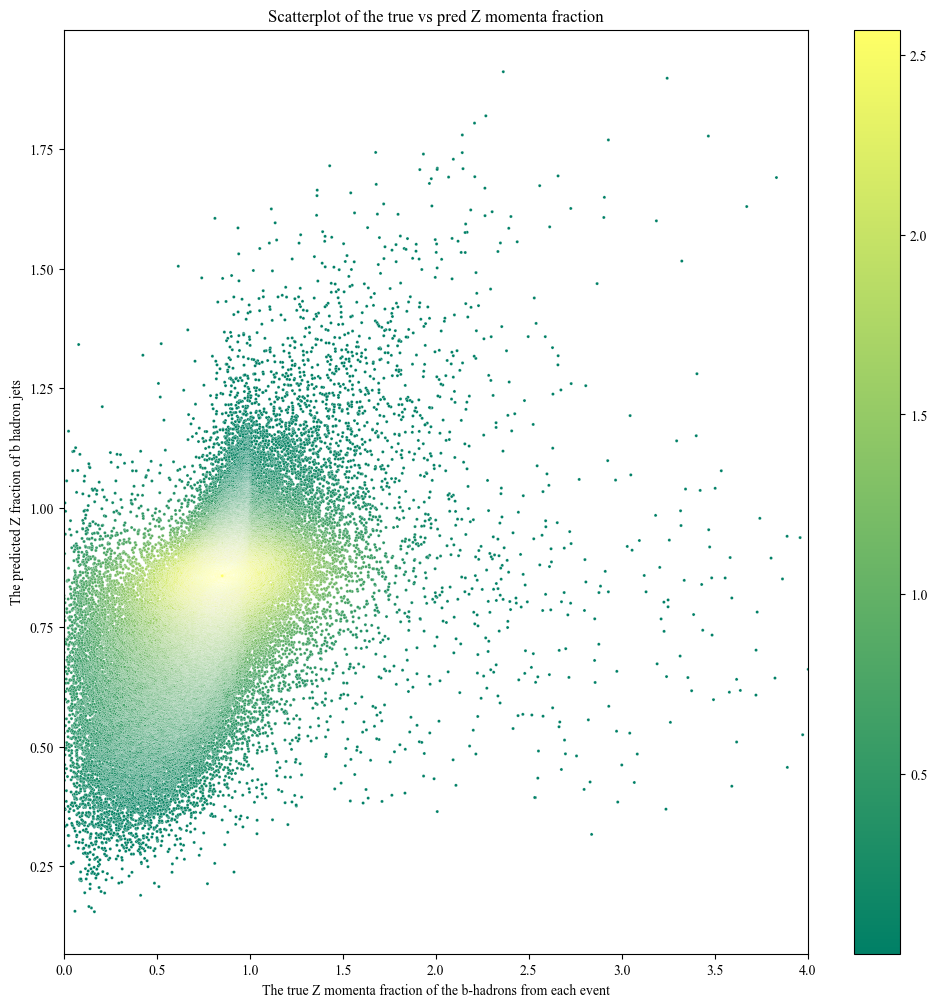

In [220]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,8]
y = Predictions_X[:,8]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "summer",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "summer", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_xlim([0,4])
ax.set_title("Scatterplot of the true vs pred Z momenta fraction")
ax.set_xlabel("The true Z momenta fraction of the b-hadrons from each event")
ax.set_ylabel("The predicted Z fraction of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted Bhadron energy of b hadron jets')

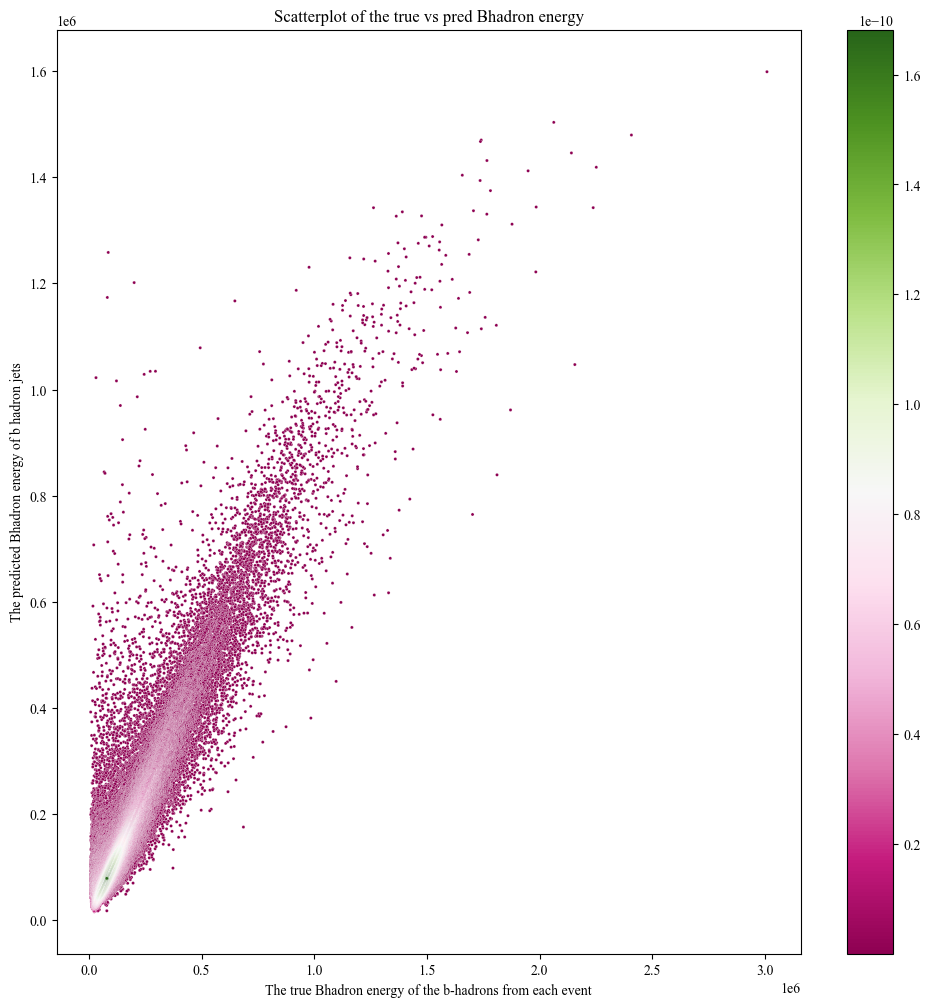

In [212]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,9]
y = Predictions_X[:,9]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "PiYG",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "PiYG", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Bhadron energy")
ax.set_xlabel("The true Bhadron energy of the b-hadrons from each event")
ax.set_ylabel("The predicted Bhadron energy of b hadron jets")

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'The predicted Bhadron projection of b hadron jets')

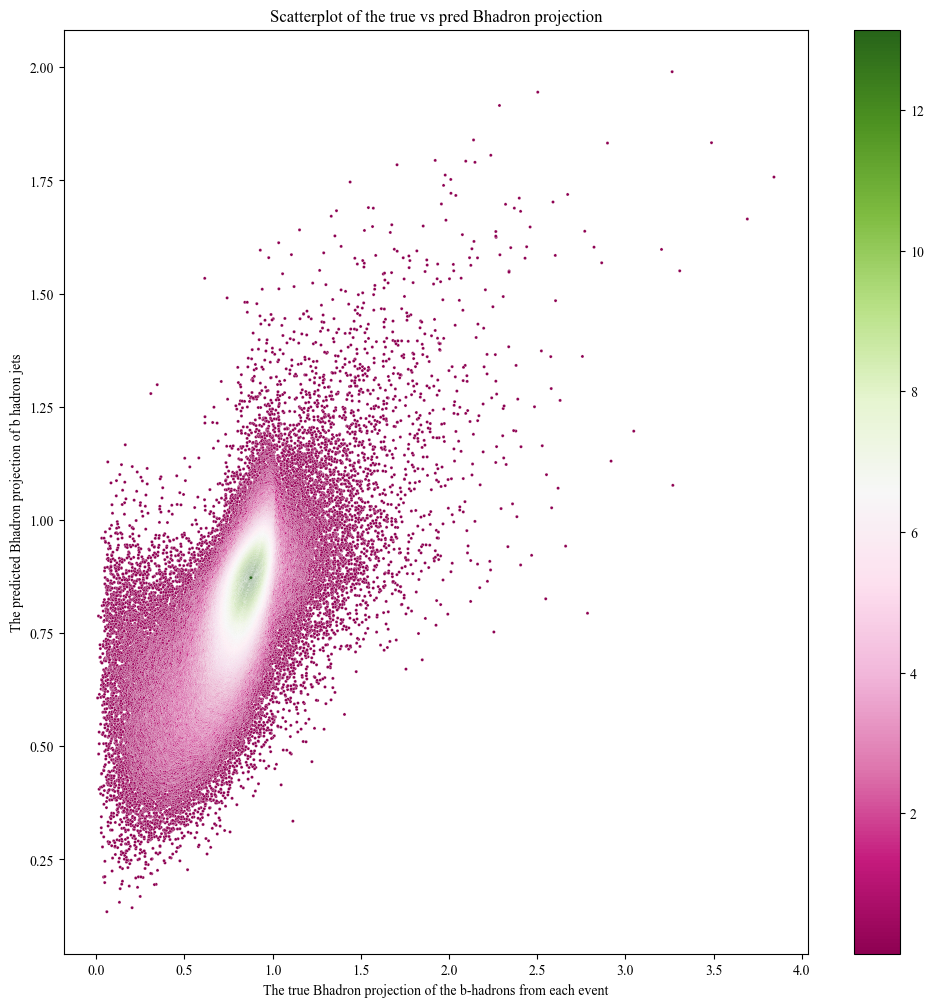

In [213]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,12]
y = Predictions_X[:,12]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "PiYG",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "PiYG", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Bhadron projection")
ax.set_xlabel("The true Bhadron projection of the b-hadrons from each event")
ax.set_ylabel("The predicted Bhadron projection of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,13]
y = Predictions_X[:,13]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "PiYG",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "PiYG", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Bhadron mass")
ax.set_xlabel("The true Bhadron mass of the b-hadrons from each event")
ax.set_ylabel("The predicted Bhadron mass of b hadron jets")

In [ ]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
fig, ax = plt.subplots(figsize = (12,12))
x = bhads_targets_clean[:,14]
y = Predictions_X[:,14]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x,
    y,
    c = z,
    s = 5,
    cmap = "PiYG",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "PiYG", norm = norm)
sm.set_array([])
im.figure.colorbar(sm)
ax.set_title("Scatterplot of the true vs pred Bhadron Secondary Vertex Displacement")
ax.set_xlabel("The true Bhadron Secondary Vertex Displacement of the b-hadrons from each event")
ax.set_ylabel("The predicted Bhadron Secondary Vertex Displacement of b hadron jets")

Text(0, 0.5, 'The predicted X momenta of b hadron jets')

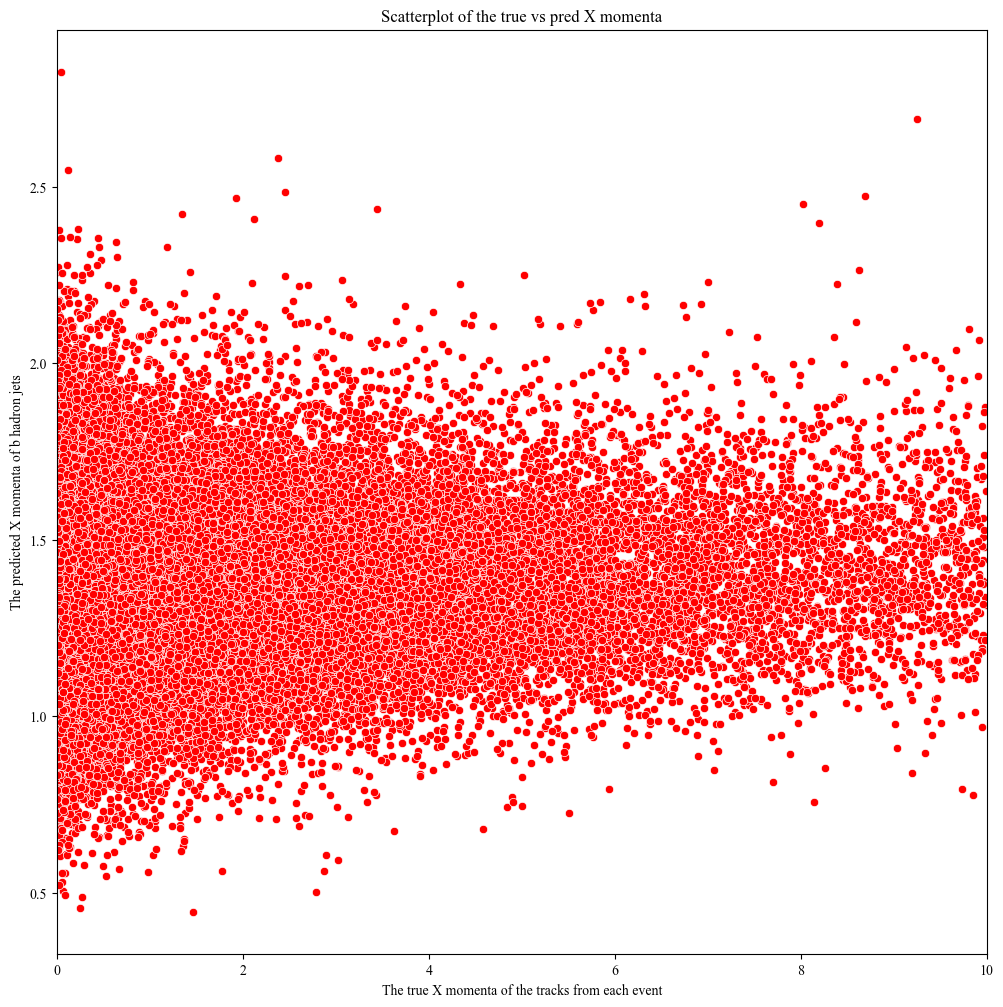

In [313]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    y = Predictions_X[:,14],
    x = bhads_targets_clean[:,14],
    color = "red"
)
ax.set_xlim(0,10)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")

In [214]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(onehot, axis = 1), np.argmax(Predictions_Mass,axis = 1)))

              precision    recall  f1-score   support

           0       0.47      0.52      0.49     41195
           1       0.46      0.58      0.51     41299
           2       0.37      0.00      0.00      9349
           3       0.51      0.01      0.01      4814

    accuracy                           0.47     96657
   macro avg       0.45      0.28      0.26     96657
weighted avg       0.46      0.47      0.43     96657



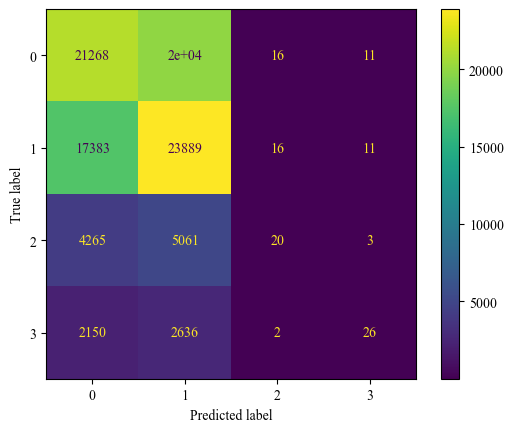

In [215]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
confusion_mat = confusion_matrix(np.argmax(onehot, axis = 1), np.argmax(Predictions_Mass,axis = 1))
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

In [ ]:
print(Predictions_X[:10,13])
print(bhads_targets_clean[:10,13])

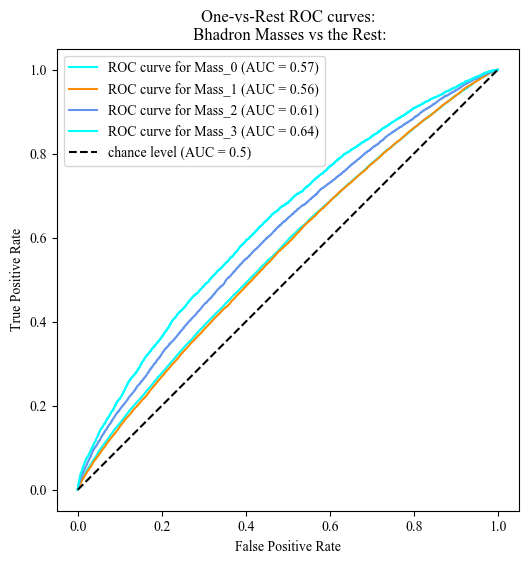

In [216]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
target_names = ["Mass_0", "Mass_1", "Mass_2", "Mass_3", "Mass_4", "Mass_5"]
fig, ax = plt.subplots(figsize = (6,6))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, colors in zip(range(4), colors):
    RocCurveDisplay.from_predictions(
        onehot[:,class_id],
        Predictions_Mass[:, class_id],
        name = f"ROC curve for {target_names[class_id]}",
        color = colors,
        ax = ax,
    )
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\n Bhadron Masses vs the Rest:")
plt.legend()
plt.show()

In [224]:
DeepSetProjector.save_weights("/home/physics/phujdj/WeightsSaved/ResidualDeepSets.ckpt")

In [225]:
# Builds the deep neural network
track_layers = [32 for x in range(2)]
jet_layers = [256 for x in range(3)]
b_jets_layers = [32 for x in range(2)]

track_layers = [np.shape(Tracks_input_scaled)[2]]+track_layers
print(track_layers)
print(np.shape(onehot)[1])
#Initializers the optimizer used for training the network
optimizer = tf.keras.optimizers.Nadam(LR)

#Build a DeepSets Projection Neural Network
DeepSetProjector2 = DeepSetsProjection(track_layers=track_layers, b_jet_layers= b_jets_layers, jet_layers=jet_layers, n_targets=np.shape(Standardized_Bhads_targets)[1], n_targets_classification= np.shape(onehot)[1], regularizer_strength= 1e-6, n_features=np.shape(b_jets_input_scaled)[1], Dropout_rate=0.0001)

[18, 32, 32]
4


In [231]:
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from HffragDeepSetsProjection import Multivariate_Gaussian_Negative_Likelihood_Loss_Curve
DeepSetProjector2.compile(
 optimizer = optimizer,
 loss = {"MultivariateLoss": Multivariate_Gaussian_Negative_Likelihood_Loss_Curve, "MassOutput":tf.keras.losses.categorical_crossentropy},
 metrics = [Mean_Squared_Error]   
)

In [226]:
path = "/home/physics/phujdj/WeightsSaved/ResidualDeepSets.ckpt"
checkpoint = os.path.dirname(path)
latest_DeepNet = tf.train.latest_checkpoint(checkpoint)

In [227]:
DeepSetProjector2.load_weights(latest_DeepNet)

In [232]:
#Evaluate the entire performance of the model
loss = DeepSetProjector2.evaluate((Tracks_input_scaled,b_jets_input_scaled),(Standardized_Bhads_targets, onehot),verbose = 2)
print("The Loaded DeepNet has loss: ", loss)

3021/3021 - 11s - loss: -6.4915e-01 - MultivariateLoss_loss: -2.6377e+00 - MassOutput_loss: 1.0827 - MultivariateLoss_Mean_Squared_Error: 0.4042 - MassOutput_Mean_Squared_Error: 0.1537 - 11s/epoch - 4ms/step
The Loaded DeepNet has loss:  [-0.6491480469703674, -2.637720823287964, 1.0827244520187378, 0.40417107939720154, 0.1536785215139389]


In [234]:
Tracks_input_scaled.shape

(96657, 32, 18)

In [235]:
means_original

array([-7.42888563e+01, -2.89466705e+01, -8.29069419e+01,  8.22878648e+04,
       -7.45740341e-04,  2.56615923e-03,  7.82061866e-01,  7.82244046e-01,
        7.79369742e-01,  1.62659268e+05,  8.25121128e+04,  3.06545151e+01,
        7.81975534e-01])

In [236]:
np.save("/home/physics/phujdj/SavedNumpyFiles/means.npy", means_original)
np.save("/home/physics/phujdj/SavedNumpyFiles/stds.npy", stds_original)